In [1]:
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor as XGBR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from feature_engine.selection import DropCorrelatedFeatures
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.model_selection import cross_val_score, train_test_split

plt.rcParams.update({'figure.max_open_warning': 0})
warnings.filterwarnings("ignore")

In [2]:
descriptors = pd.read_excel(r"descriptors_1.xlsx")
data = pd.read_excel(r"final_data.xlsx")

In [3]:
def delete_low_var(var, descriptor):
    """This function removes low variance features."""
    sel = VarianceThreshold(threshold=var)
    X = descriptor.iloc[:, 0:]
    X_select = sel.fit_transform(X)
    descs = descriptor.columns
    de_low_var = pd.DataFrame(X_select, columns=np.array(descs)[sel.get_support()])
    
    return de_low_var

In [4]:
def standardization(descriptor):
    """This function standard the data."""
    scaler = StandardScaler()
    regulation = pd.DataFrame(scaler.fit_transform(descriptors))
    regulation.columns = descriptor.columns
    
    return regulation

In [5]:
def KDE(train_data, test_data, figname):
    """"This function plots the kernel density estimates for the training and test sets."""
    dist_cols = 6
    dist_rows = len(train_data.columns)
    plt.figure(figsize=(4 * dist_cols, 4 * dist_rows))

    i = 1
    for col in train_data.columns:
        # noinspection PyBroadException
        try:
            plt.subplot(dist_rows, dist_cols, i)
            # draw the kernel density estimate of the training set
            sns.kdeplot(train_data[col], color='red', shade=True)
            # draw the kernel density estimate of the test set
            ax = sns.kdeplot(test_data[col], color='blue', shade=True)
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
            ax.legend(["train", "test"])
            i += 1
        except:
            print(col)
            i += 1
    plt.tight_layout()
    plt.savefig(figname, bbox_inches='tight', dpi=300)
    plt.show()

In [6]:
def XGboost_score(Xtrain, Xtest, Ytrain, Ytest):
    """This function gets the r2, MSE, r2 and NMSE values 
    of the XGBoost function test set, ten-fold cross-validation.
    """
    # build the model
    XGboost = XGBR(n_estimators=100, random_state=42)
    # train the model
    regressor = XGboost.fit(Xtrain, Ytrain)
    # calculate mean NMSE value for ten-fold cross-validation
    score = cross_val_score(XGboost, Xtrain, Ytrain, scoring='neg_mean_squared_error', cv=10).mean()
    # calculate mean R2 value for ten-fold cross-validation
    scores = cross_val_score(XGboost, Xtrain, Ytrain, cv=10).mean()
    # calculate R2 value
    r2 = regressor.score(Xtest, Ytest)
    # calculate MSE value
    mse = MSE(Ytest, regressor.predict(Xtest))
    print('XGboost score')
    print(' r2  ', r2)
    print(' MSE ', mse)
    print(' NMSE  ', score)
    print('mean_r2', scores)

In [8]:
def wrapper(start, end, step, X, regressor):
    """This function finds the eigenvalue corresponding to the best score in a given range."""
    score = []
    # calculate neg MSE score in input range
    for i in range(start, end, step):
        chooser = RFE(regressor, n_features_to_select=i, step=50).fit_transform(X, y)
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(chooser, y, test_size=0.2, random_state=42)
        model = regressor.fit(Xtrain, Ytrain)
        # calculate NMSE values for ten-fold cross-validation
        once = cross_val_score(model, Xtrain, Ytrain, cv=10, scoring='neg_mean_squared_error').mean()
        score.append(once)
    n_features = (score.index(max(score))) * step + start
    print(max(score), n_features)
    
    # draw the score curve and observe the trend
    plt.figure(figsize=(20, 12))
    font = {'family': 'Times New Roman',
            'size': 20}
    ax = plt.subplot(1, 1, 1)
    ax.plot(range(start, end, step), score)
    ax.set_xlabel("Number of features", font)
    ax.set_ylabel("neg mse score", font)
    plt.show()
    
    return n_features

In [11]:
features = descriptors.copy()
# filter low varience feature
descriptors = delete_low_var(0, descriptors)
# feature standardization
standard = standardization(descriptors)

In [12]:
# standardized XGBoost score
y = data['logVDss']
x_train, x_test, y_train, y_test = train_test_split(standard, y, test_size=0.2, random_state=42)
XGboost_score(x_train, x_test, y_train, y_test)

XGboost score
 r2   0.7827418945279621
 MSE  0.08536031834455231
 NMSE   -0.09136159377075019
mean_r2 0.7622095743948644


In [13]:
# remove high correlation features
tr = DropCorrelatedFeatures(variables=None, method="pearson", threshold=0.95)
drop_corr = tr.fit_transform(standard)
print("feature dimension after removing highly correlated: ", drop_corr.shape)
x_train, x_test, y_train, y_test = train_test_split(drop_corr, y, test_size=0.2, random_state=42)
XGboost_score(x_train, x_test, y_train, y_test)

(2370, 696)
XGboost score
 r2   0.7607776137192601
 MSE  0.09399004471525031
 NMSE   -0.09266418719833916
mean_r2 0.7588134503346771


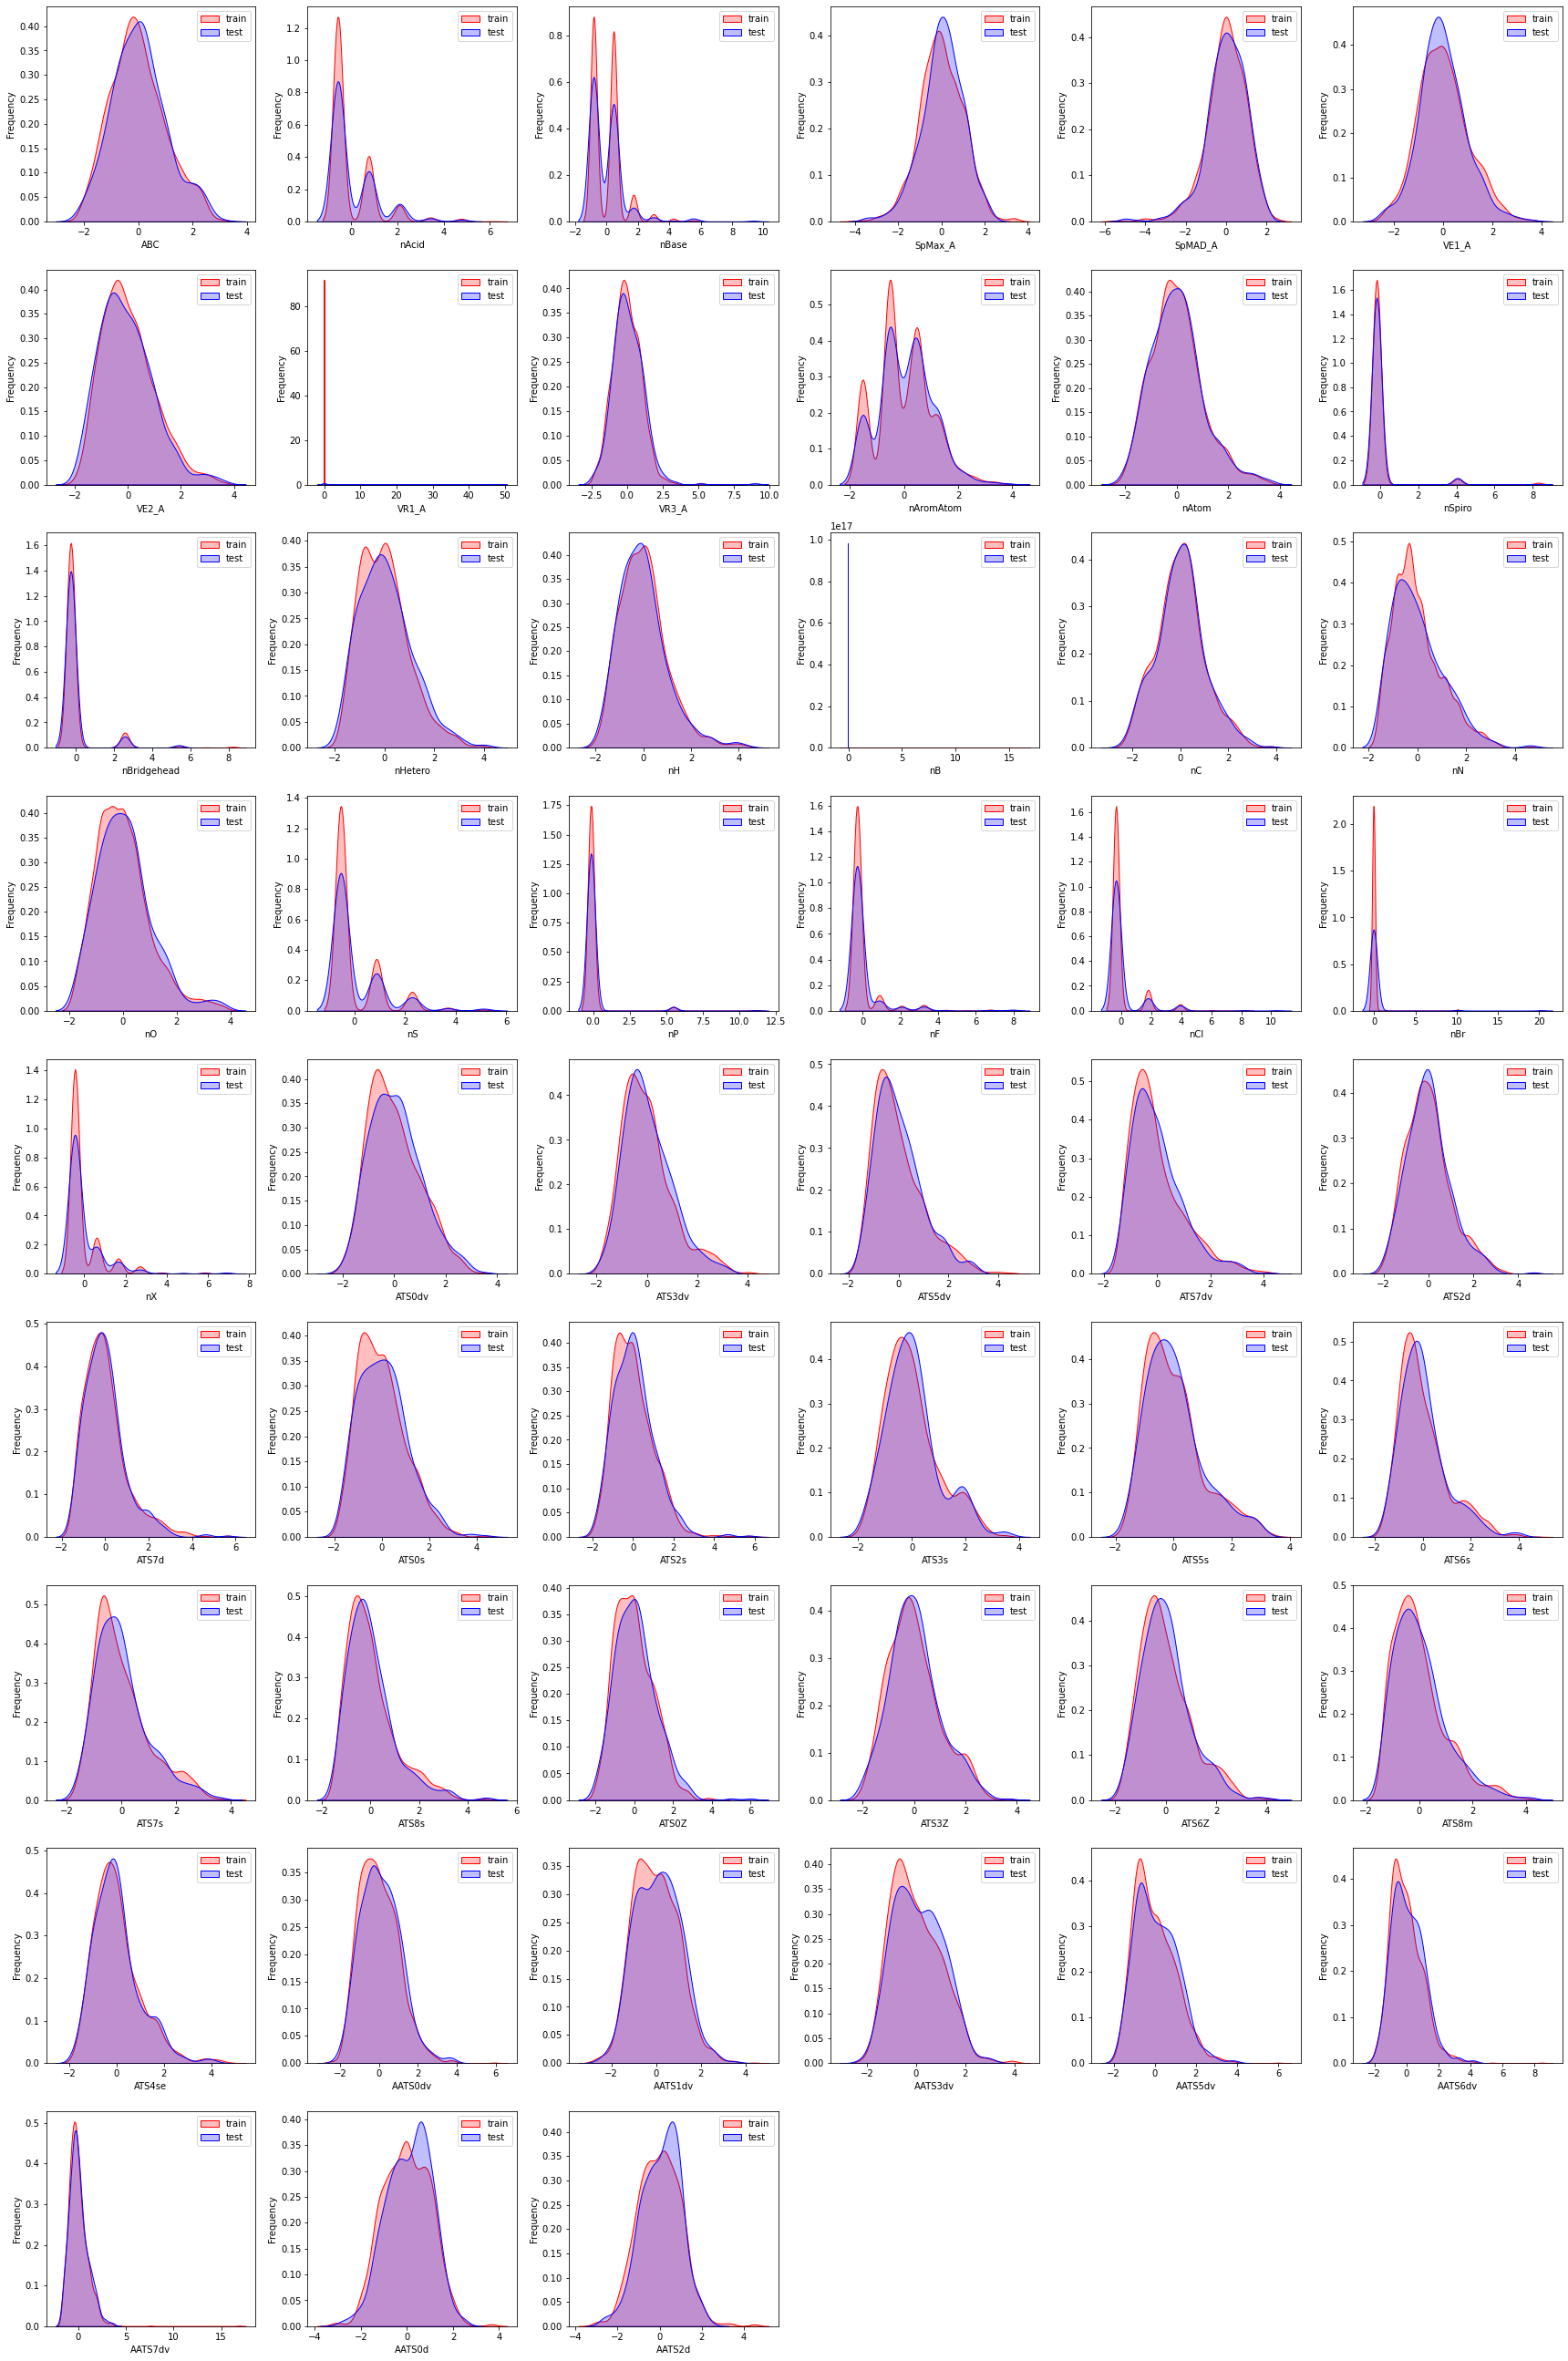

In [14]:
# draw the kernel density estimates for 
# the first 50 features in the training and test sets
train = x_train.loc[:, :x_train.columns[50]]
test = x_test.loc[:, :x_test.columns[50]]
KDE(train, test, "supplemental_fig1.png")

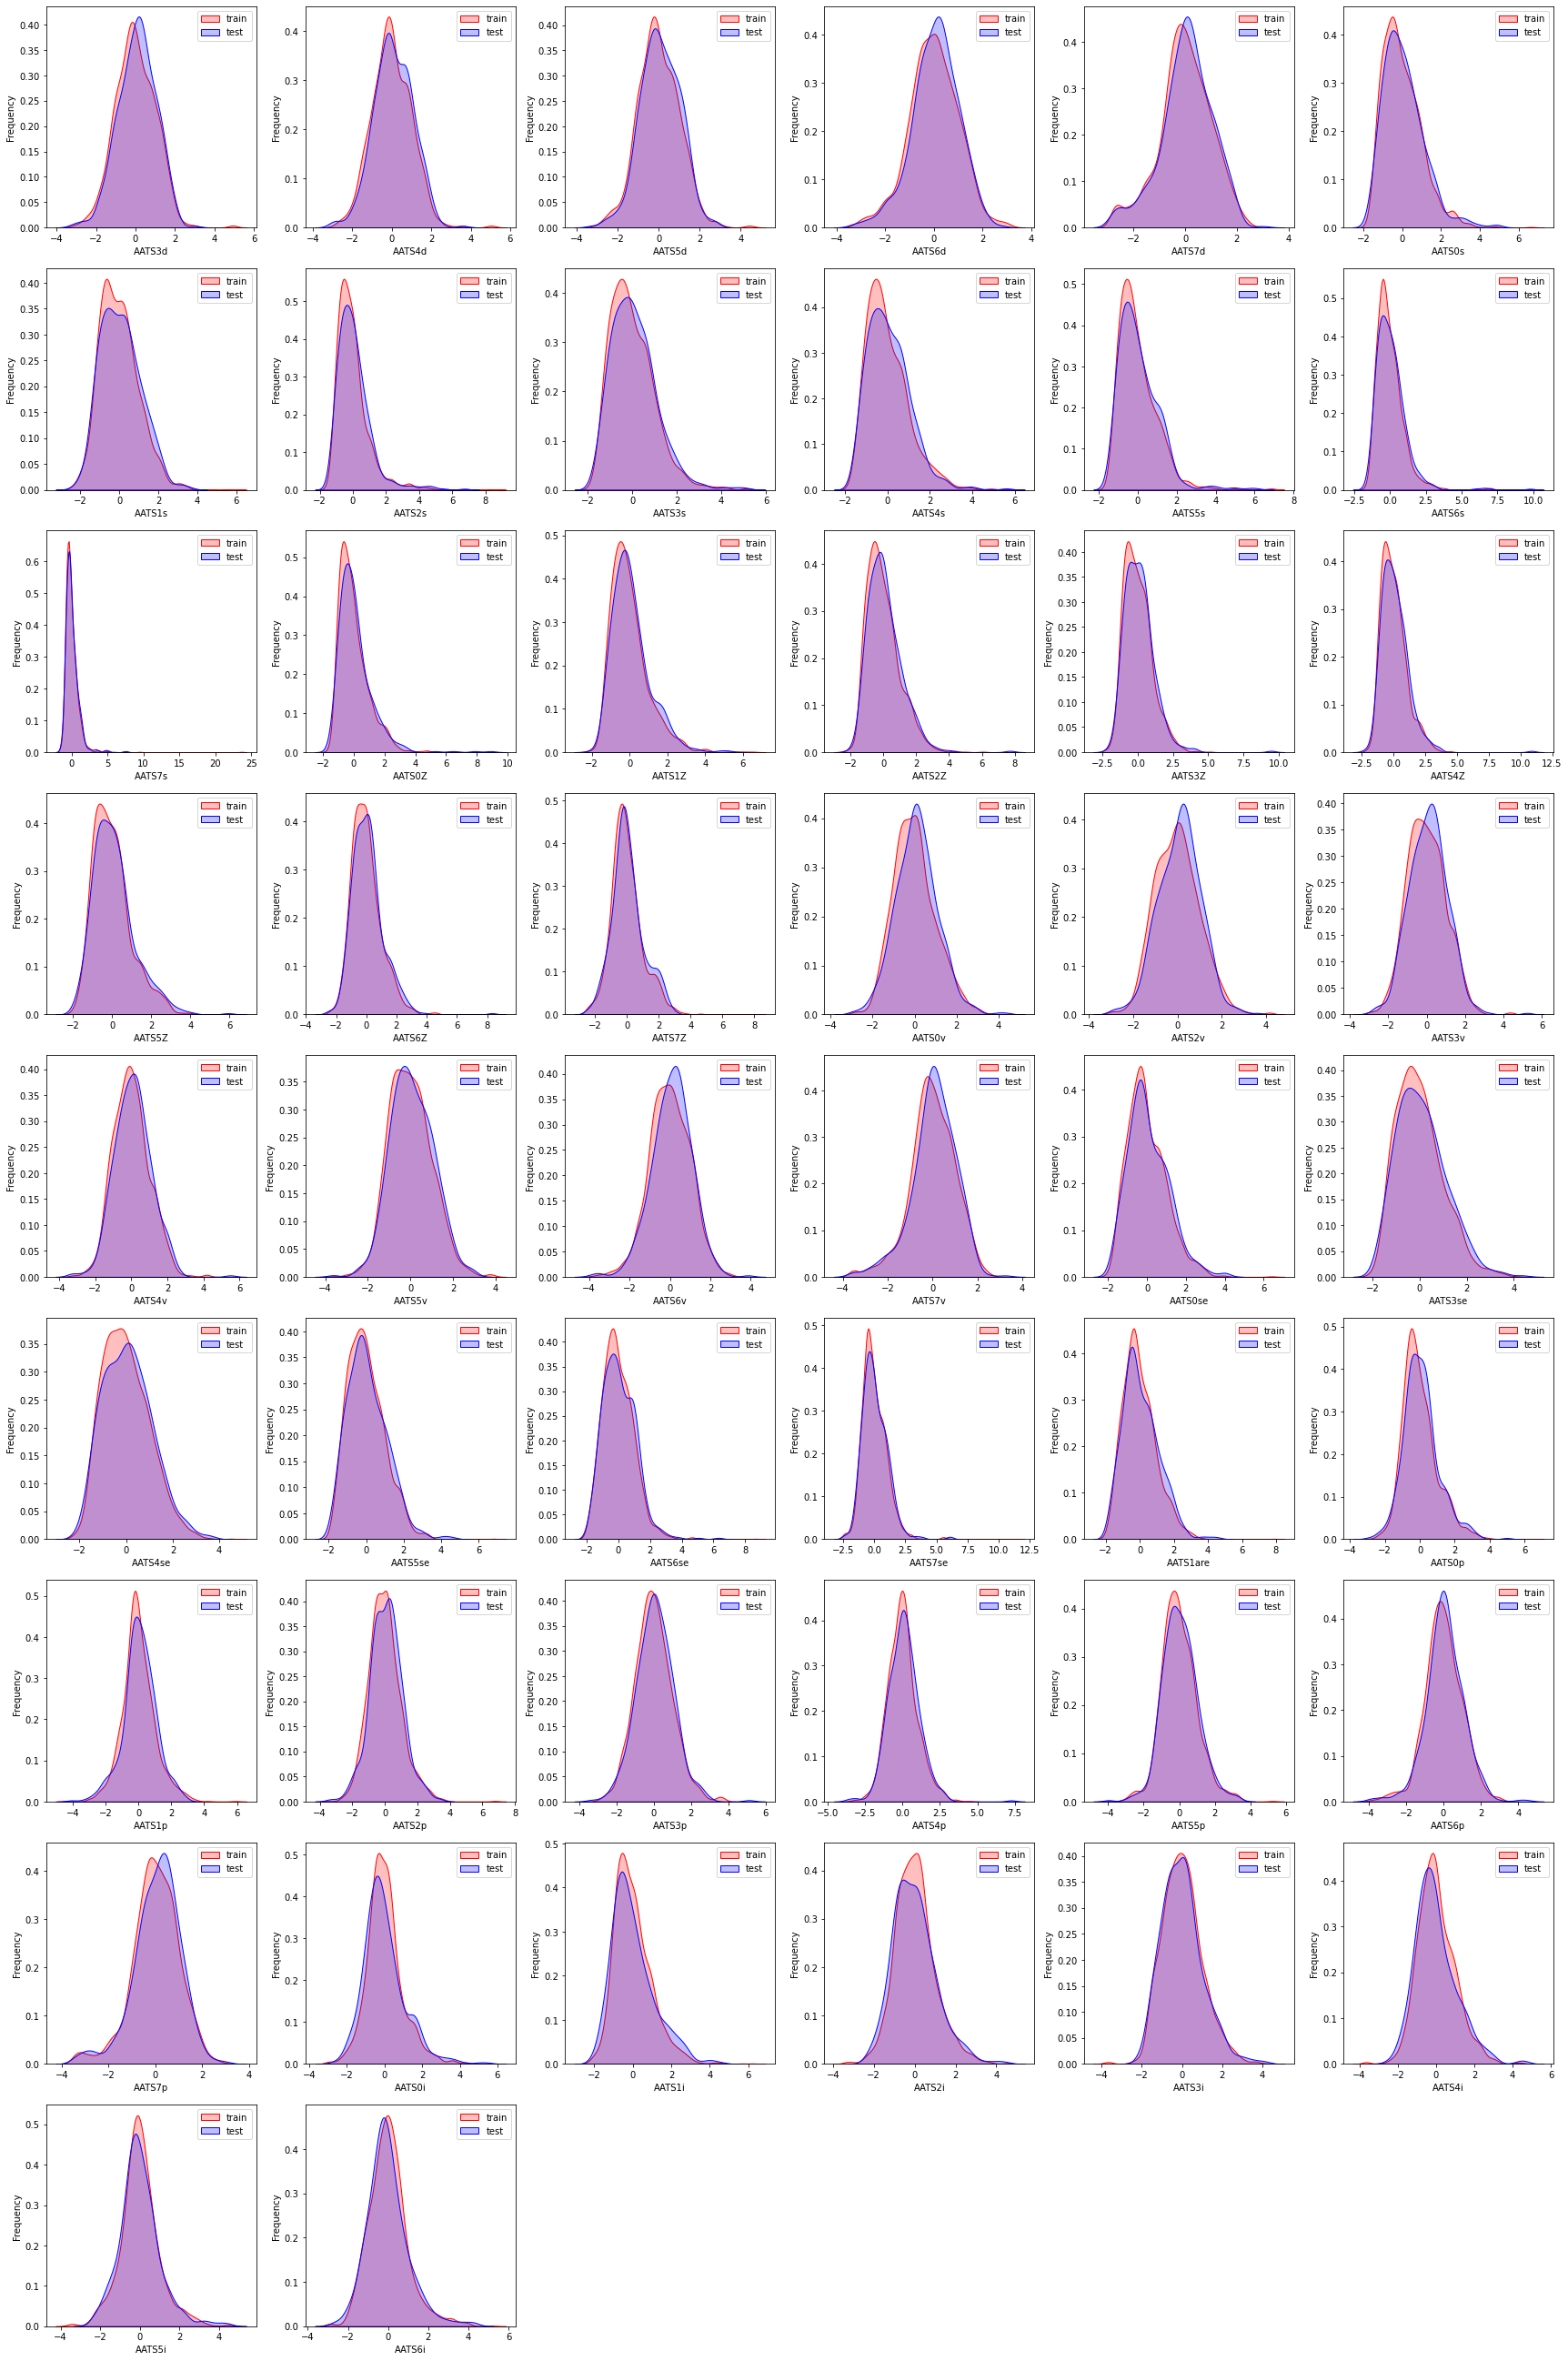

In [15]:
# draw the probability density estimates of the 51-100th features
# in the training set and test set
train = x_train.loc[:, x_train.columns[51]:x_train.columns[100]]
test = x_test.loc[:, x_test.columns[51]:x_test.columns[100]]
KDE(train, test, "supplemental_fig2.png")

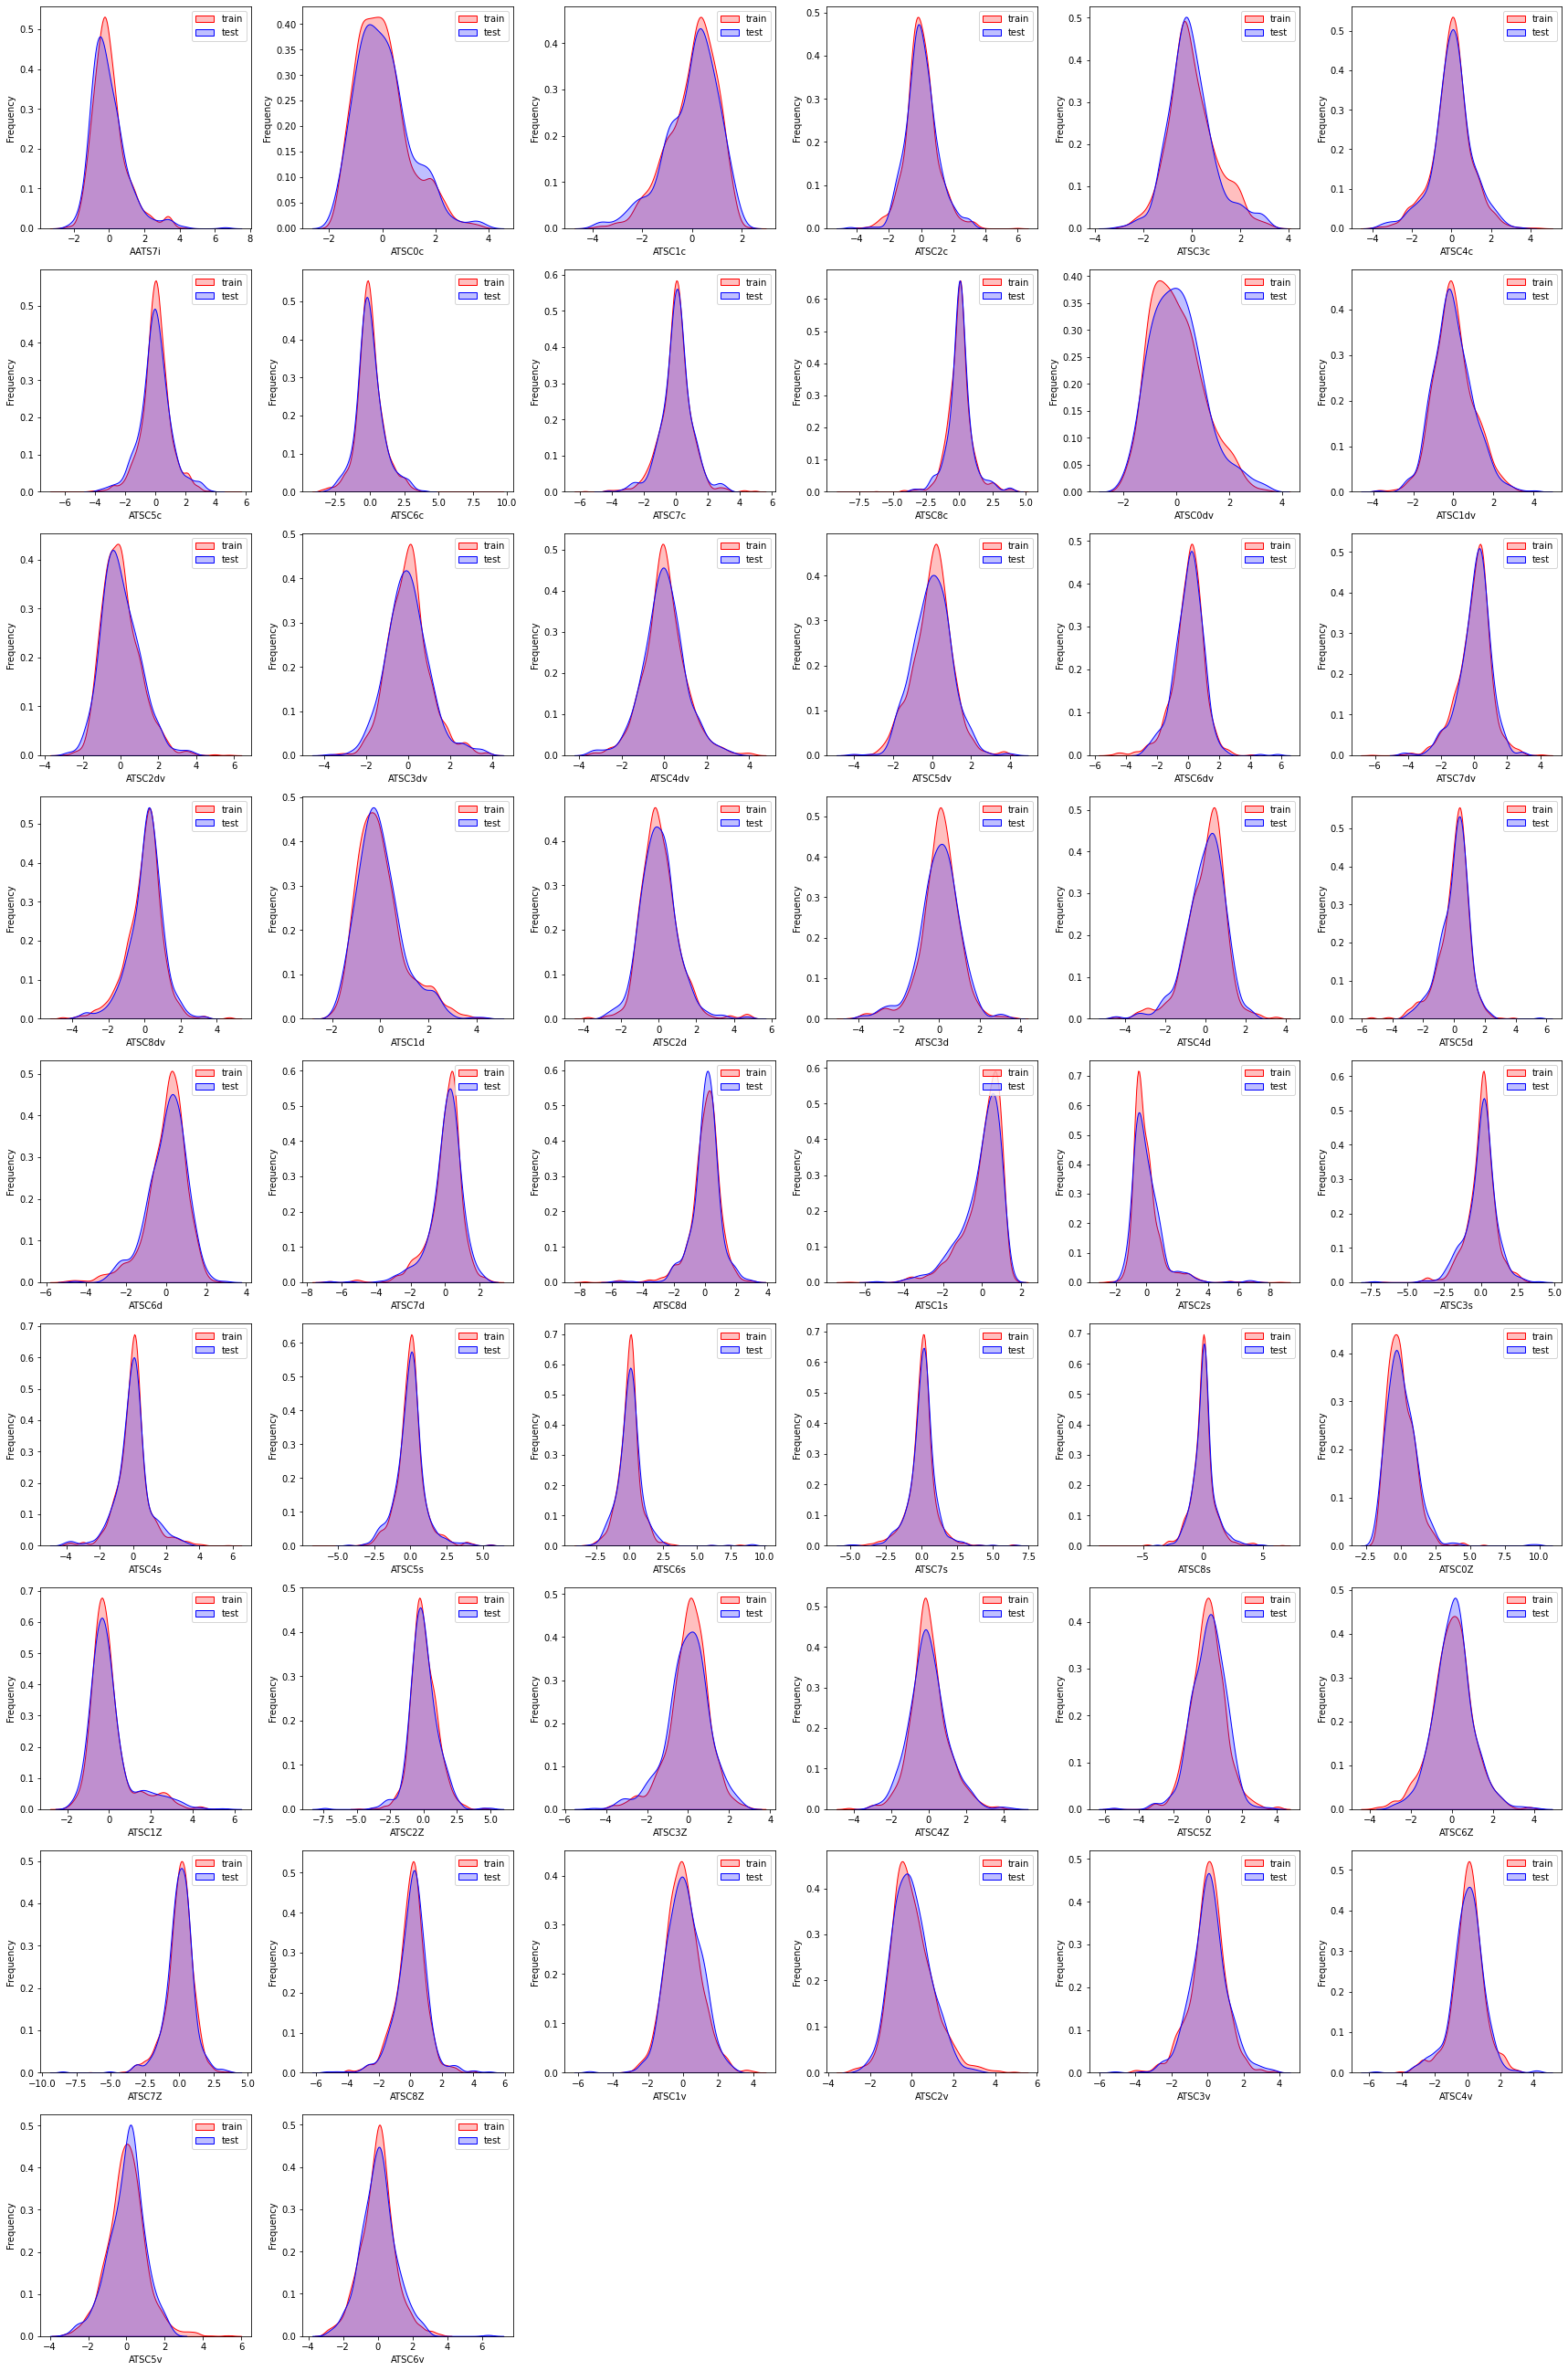

In [16]:
# draw the probability density estimates of the 101-150th features 
# in the training set and test set
train = x_train.loc[:, x_train.columns[101]:x_train.columns[150]]
test = x_test.loc[:, x_test.columns[101]:x_test.columns[150]]
KDE(train, test, "supplemental_fig3.png")

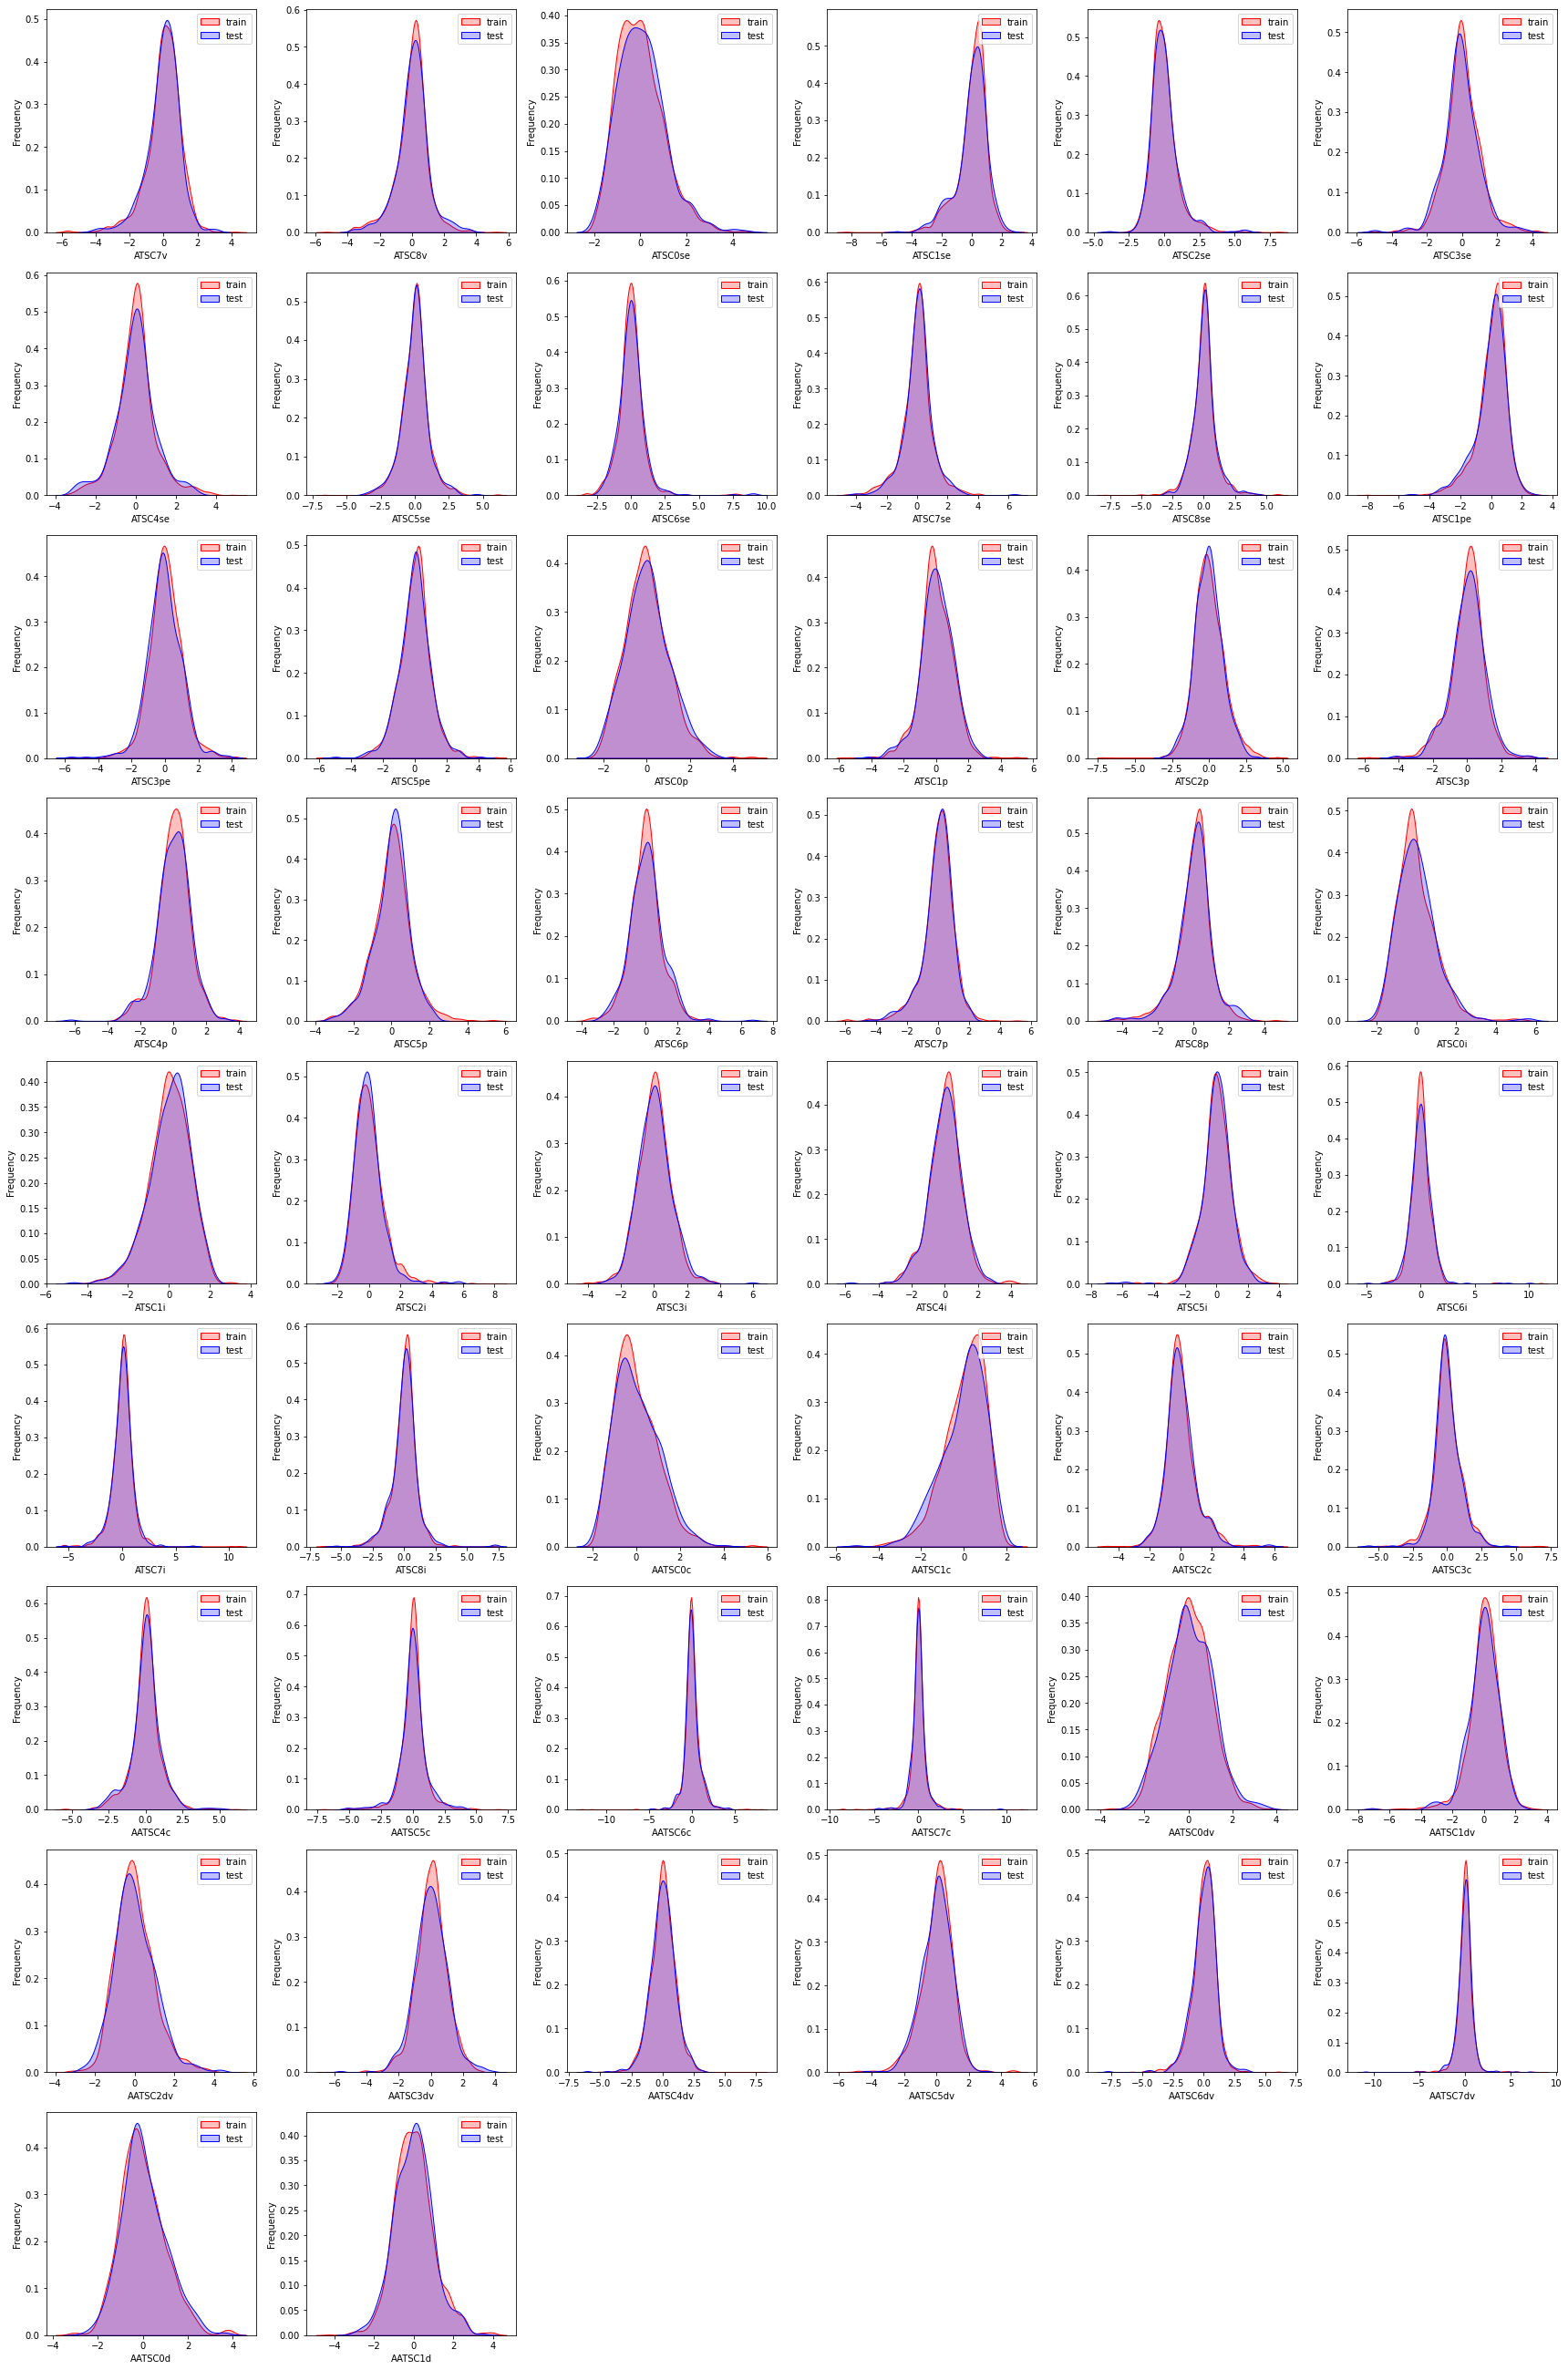

In [17]:
# draw the probability density estimates of the 151-200th features 
# in the training set and test set
train = x_train.loc[:, x_train.columns[151]:x_train.columns[200]]
test = x_test.loc[:, x_test.columns[151]:x_test.columns[200]]
KDE(train, test, "supplemental_fig4.png")

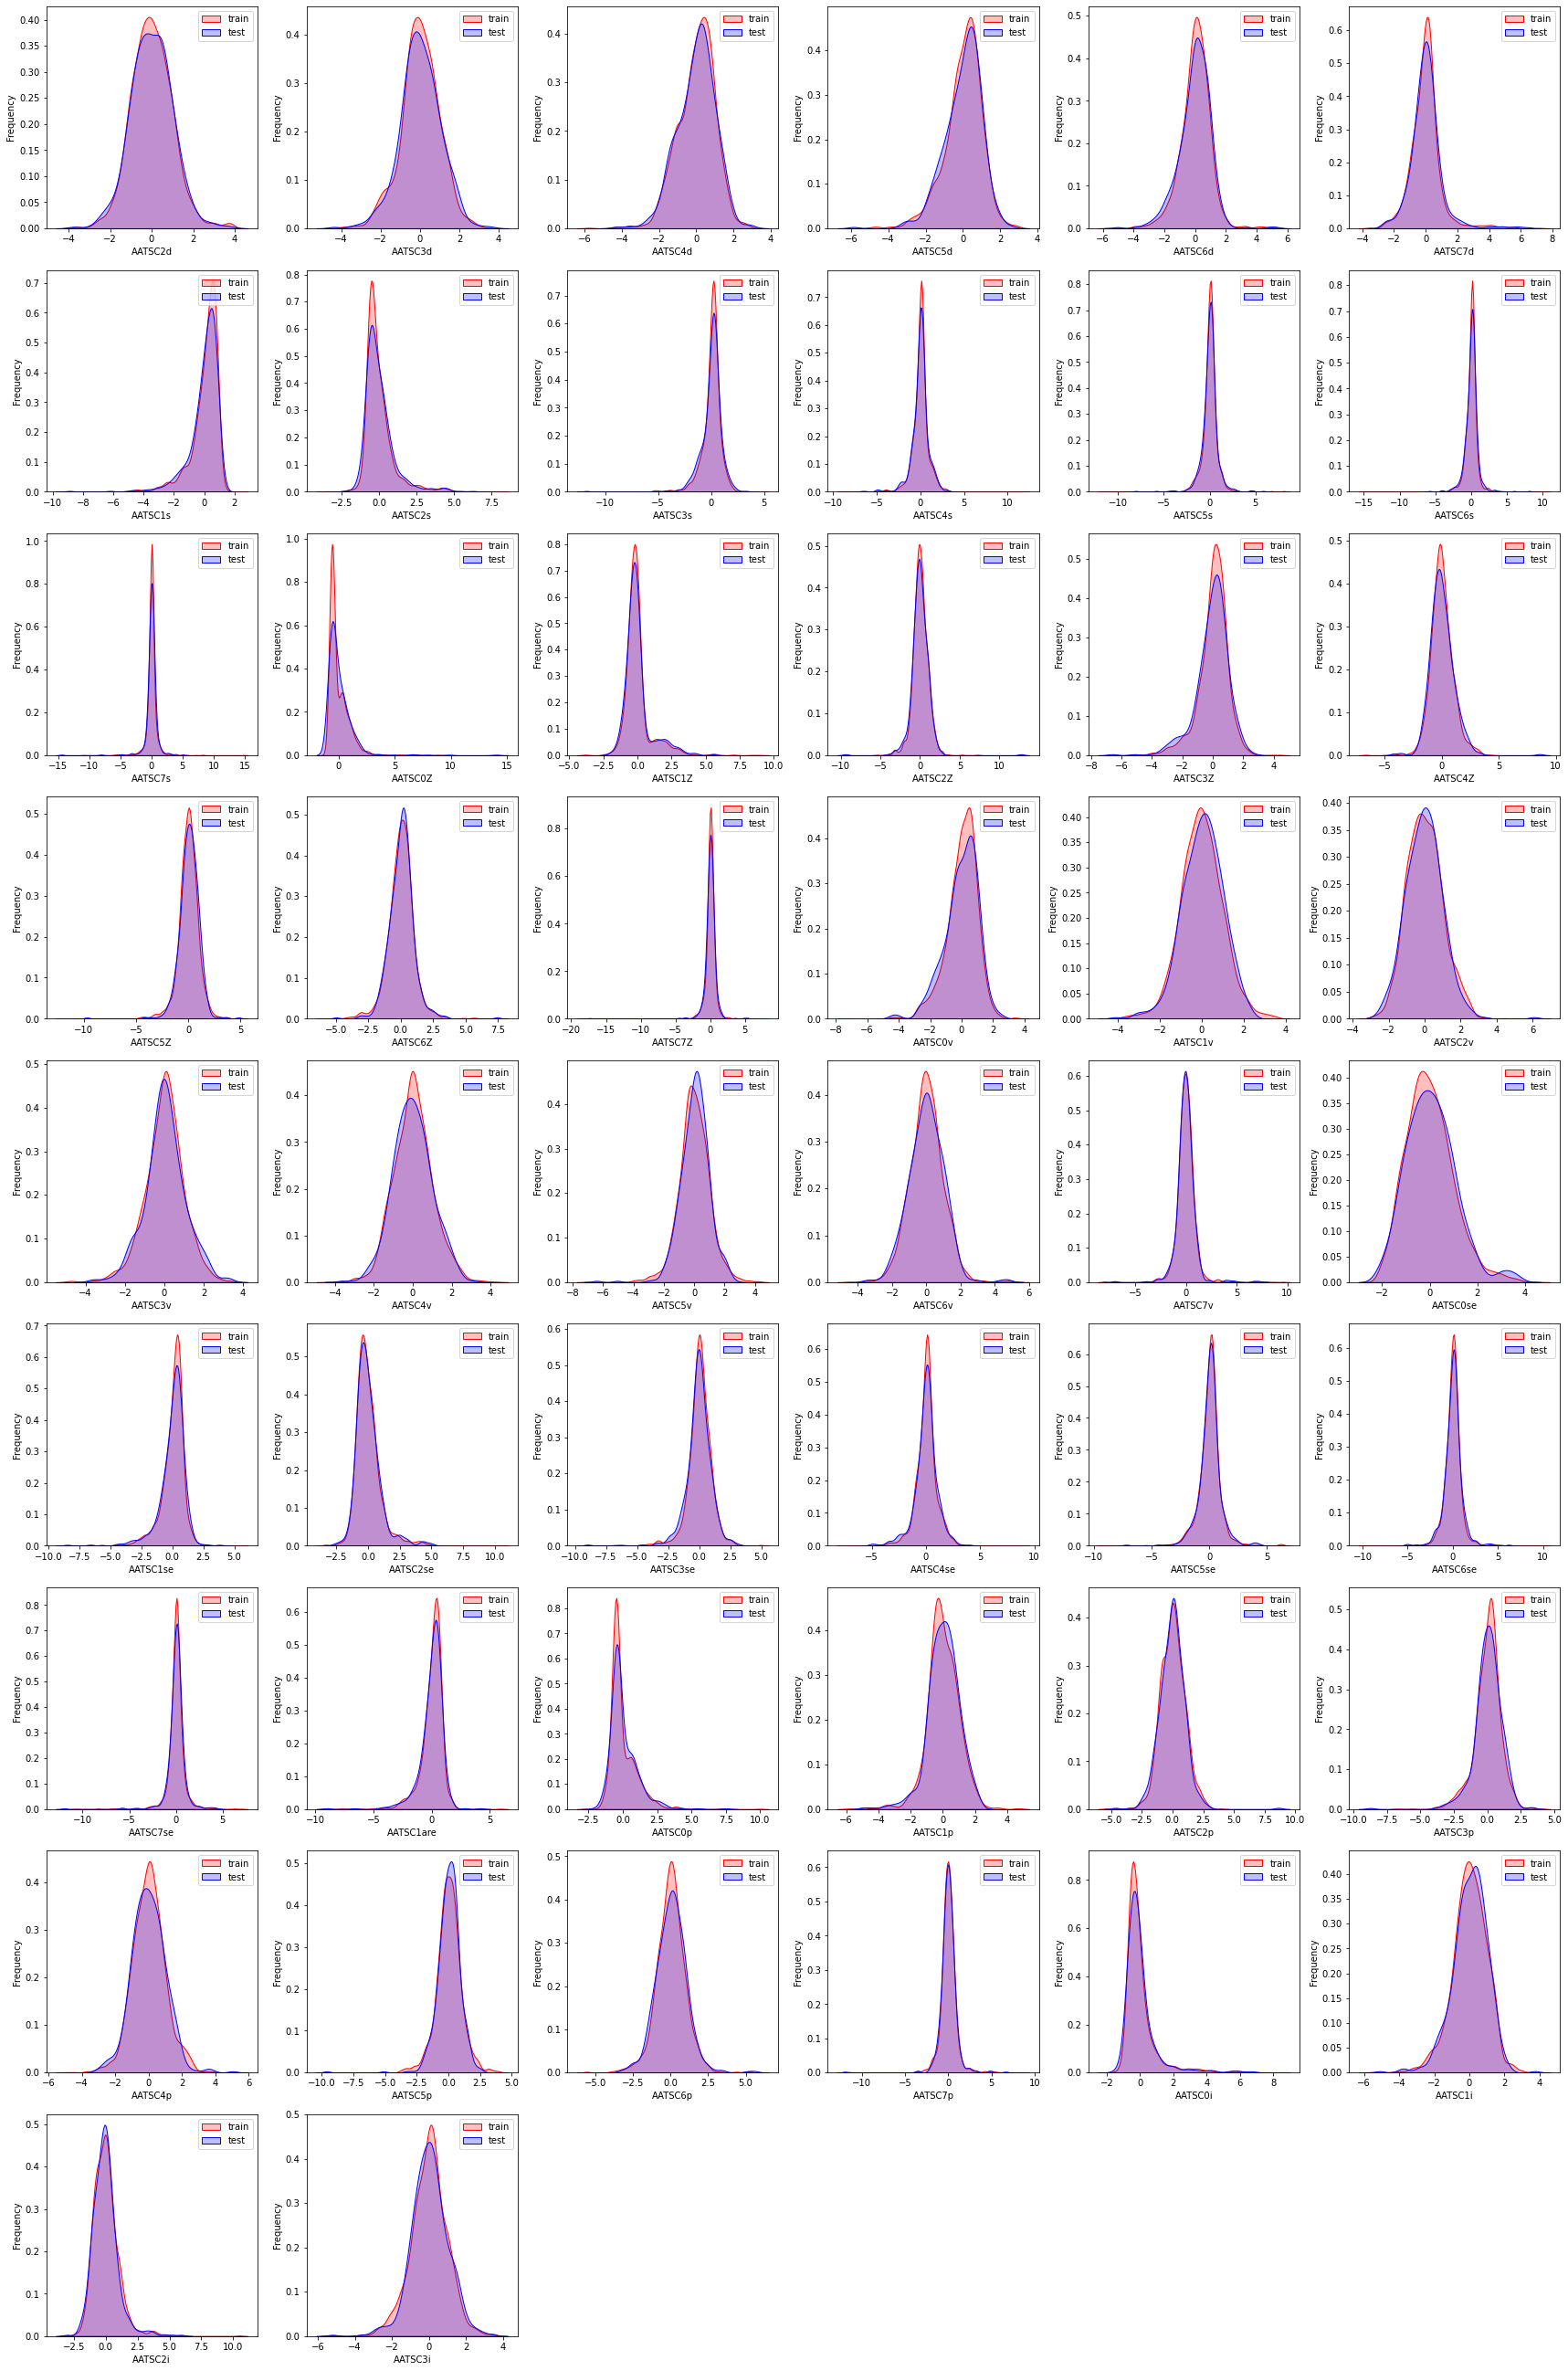

In [18]:
# draw the probability density estimates of the 201-250th features 
# in the training set and test set
train = x_train.loc[:, x_train.columns[201]:x_train.columns[250]]
test = x_test.loc[:, x_test.columns[201]:x_test.columns[250]]
KDE(train, test, "supplemental_fig5.png")

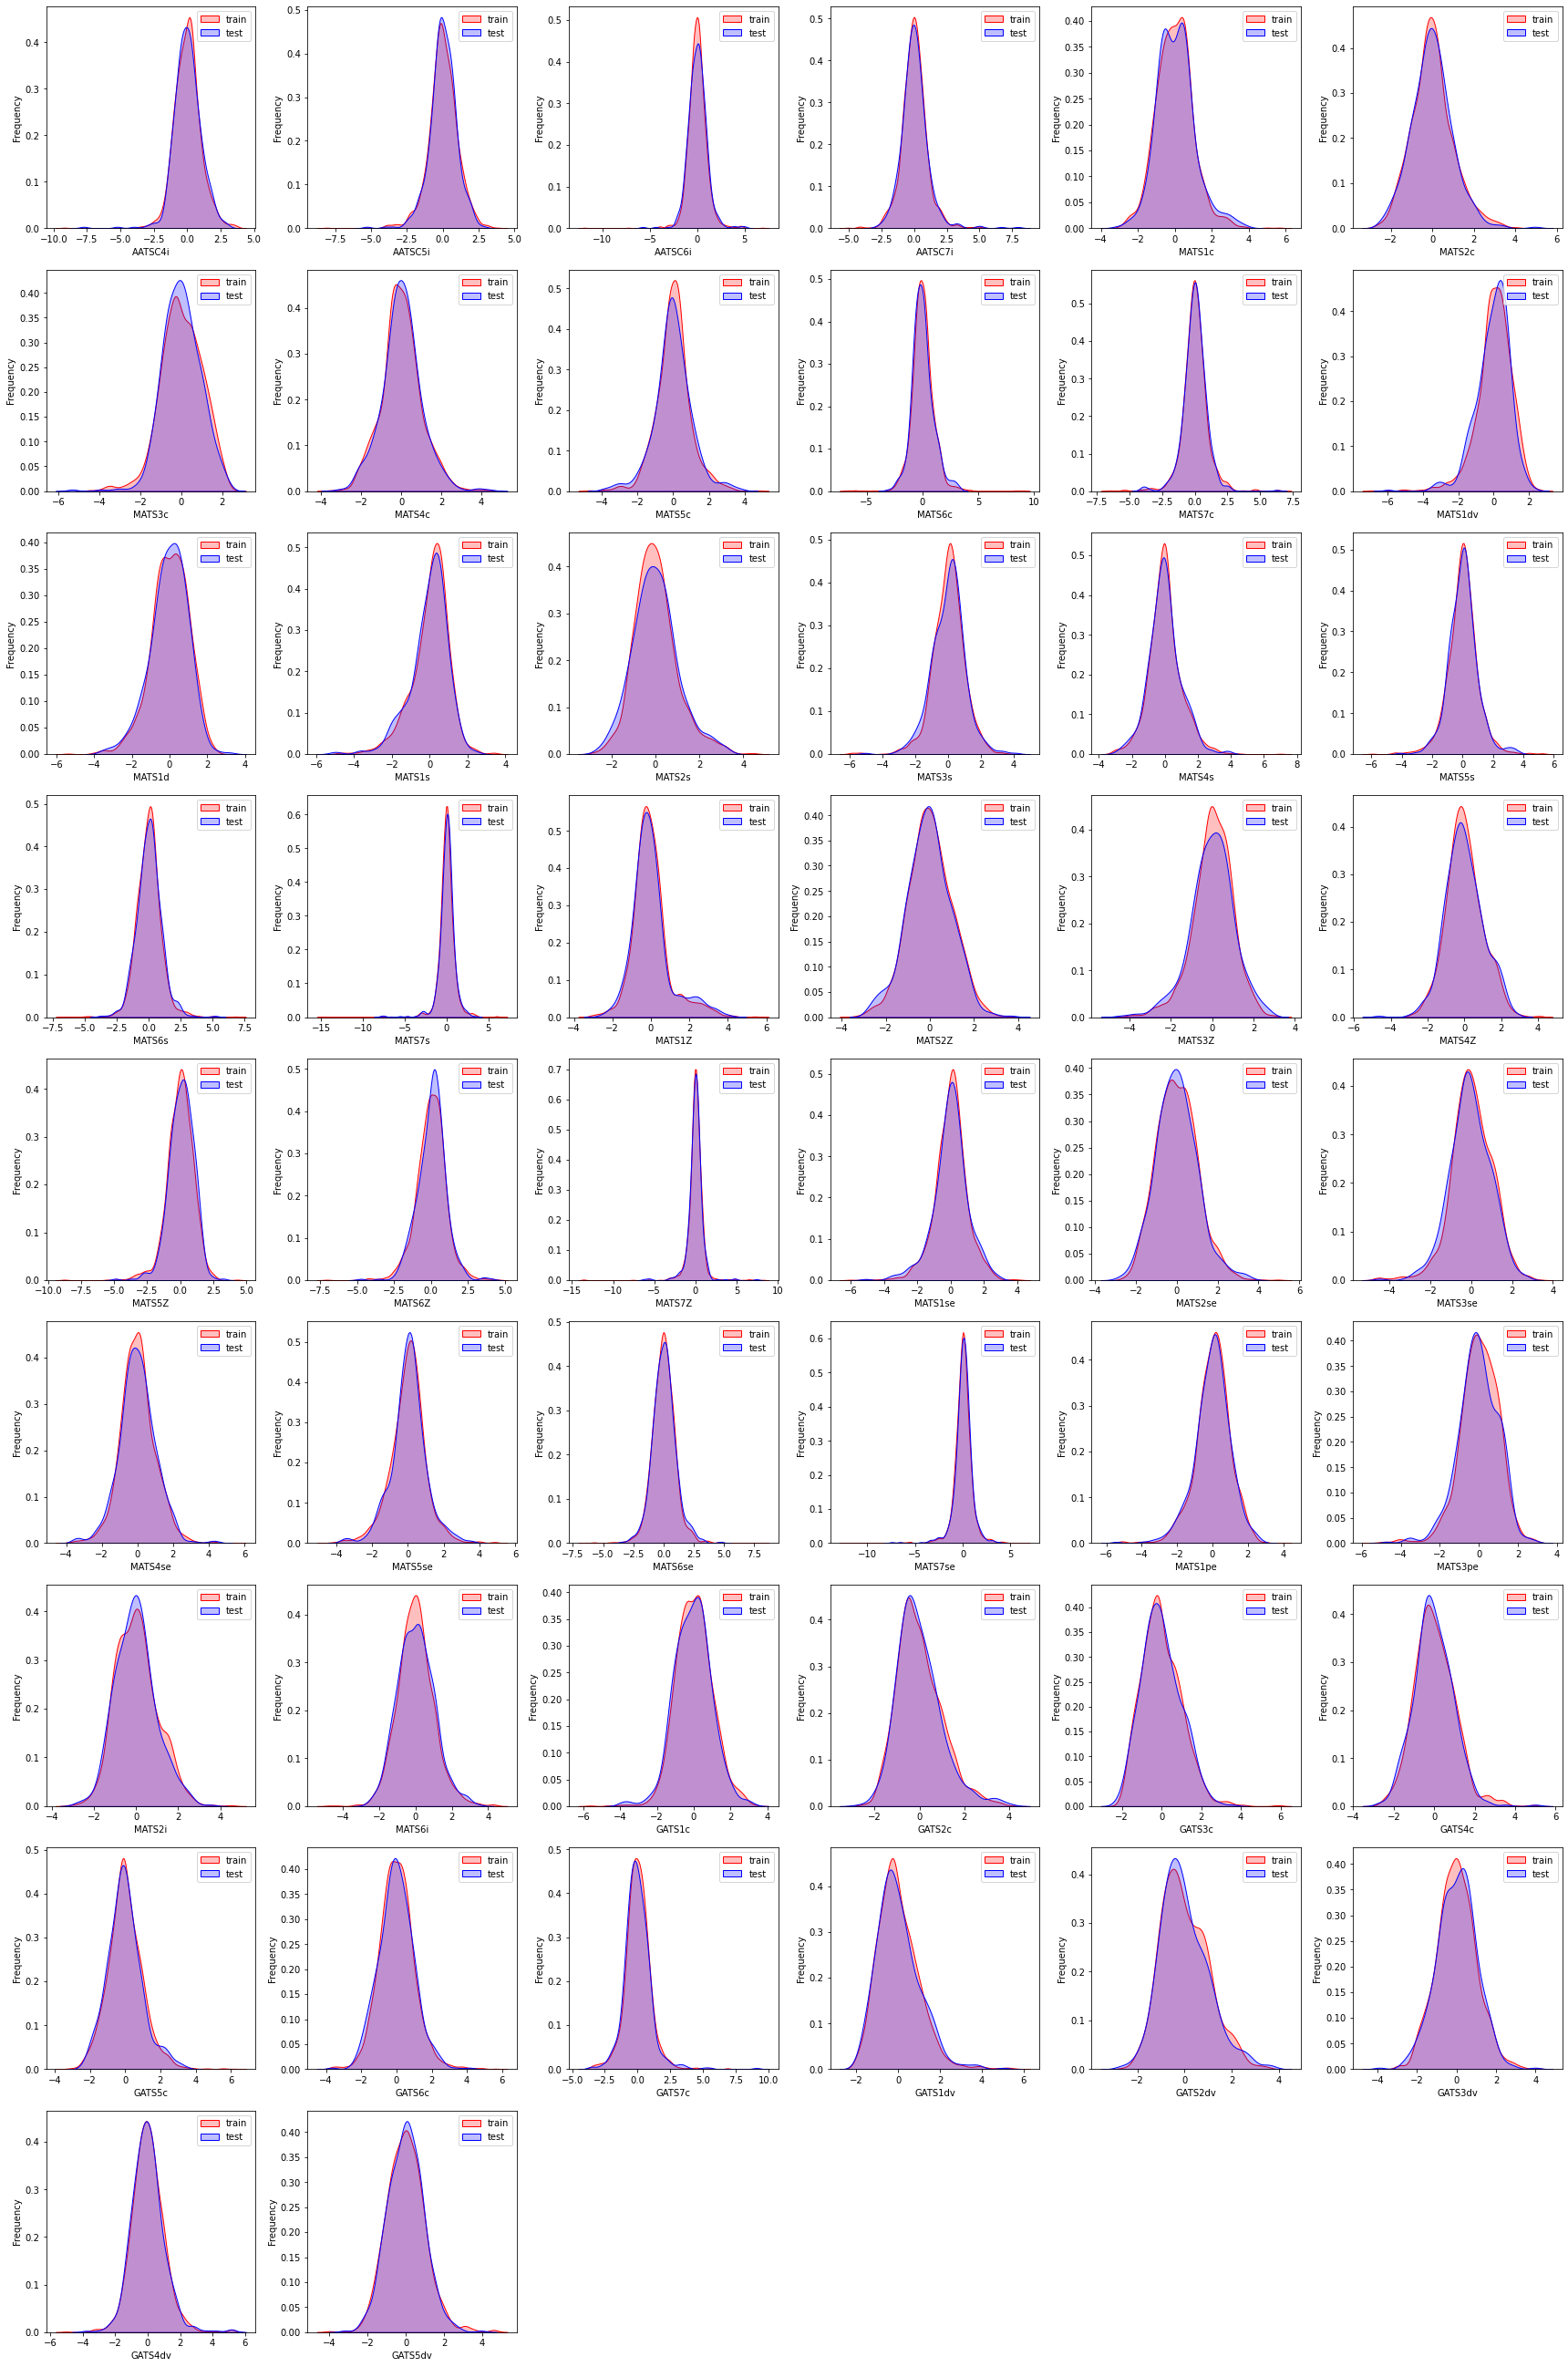

In [19]:
# draw the probability density estimates of the 251-300th features 
# in the training set and test set
train = x_train.loc[:, x_train.columns[251]:x_train.columns[300]]
test = x_test.loc[:, x_test.columns[251]:x_test.columns[300]]
KDE(train, test, "supplemental_fig6.png")

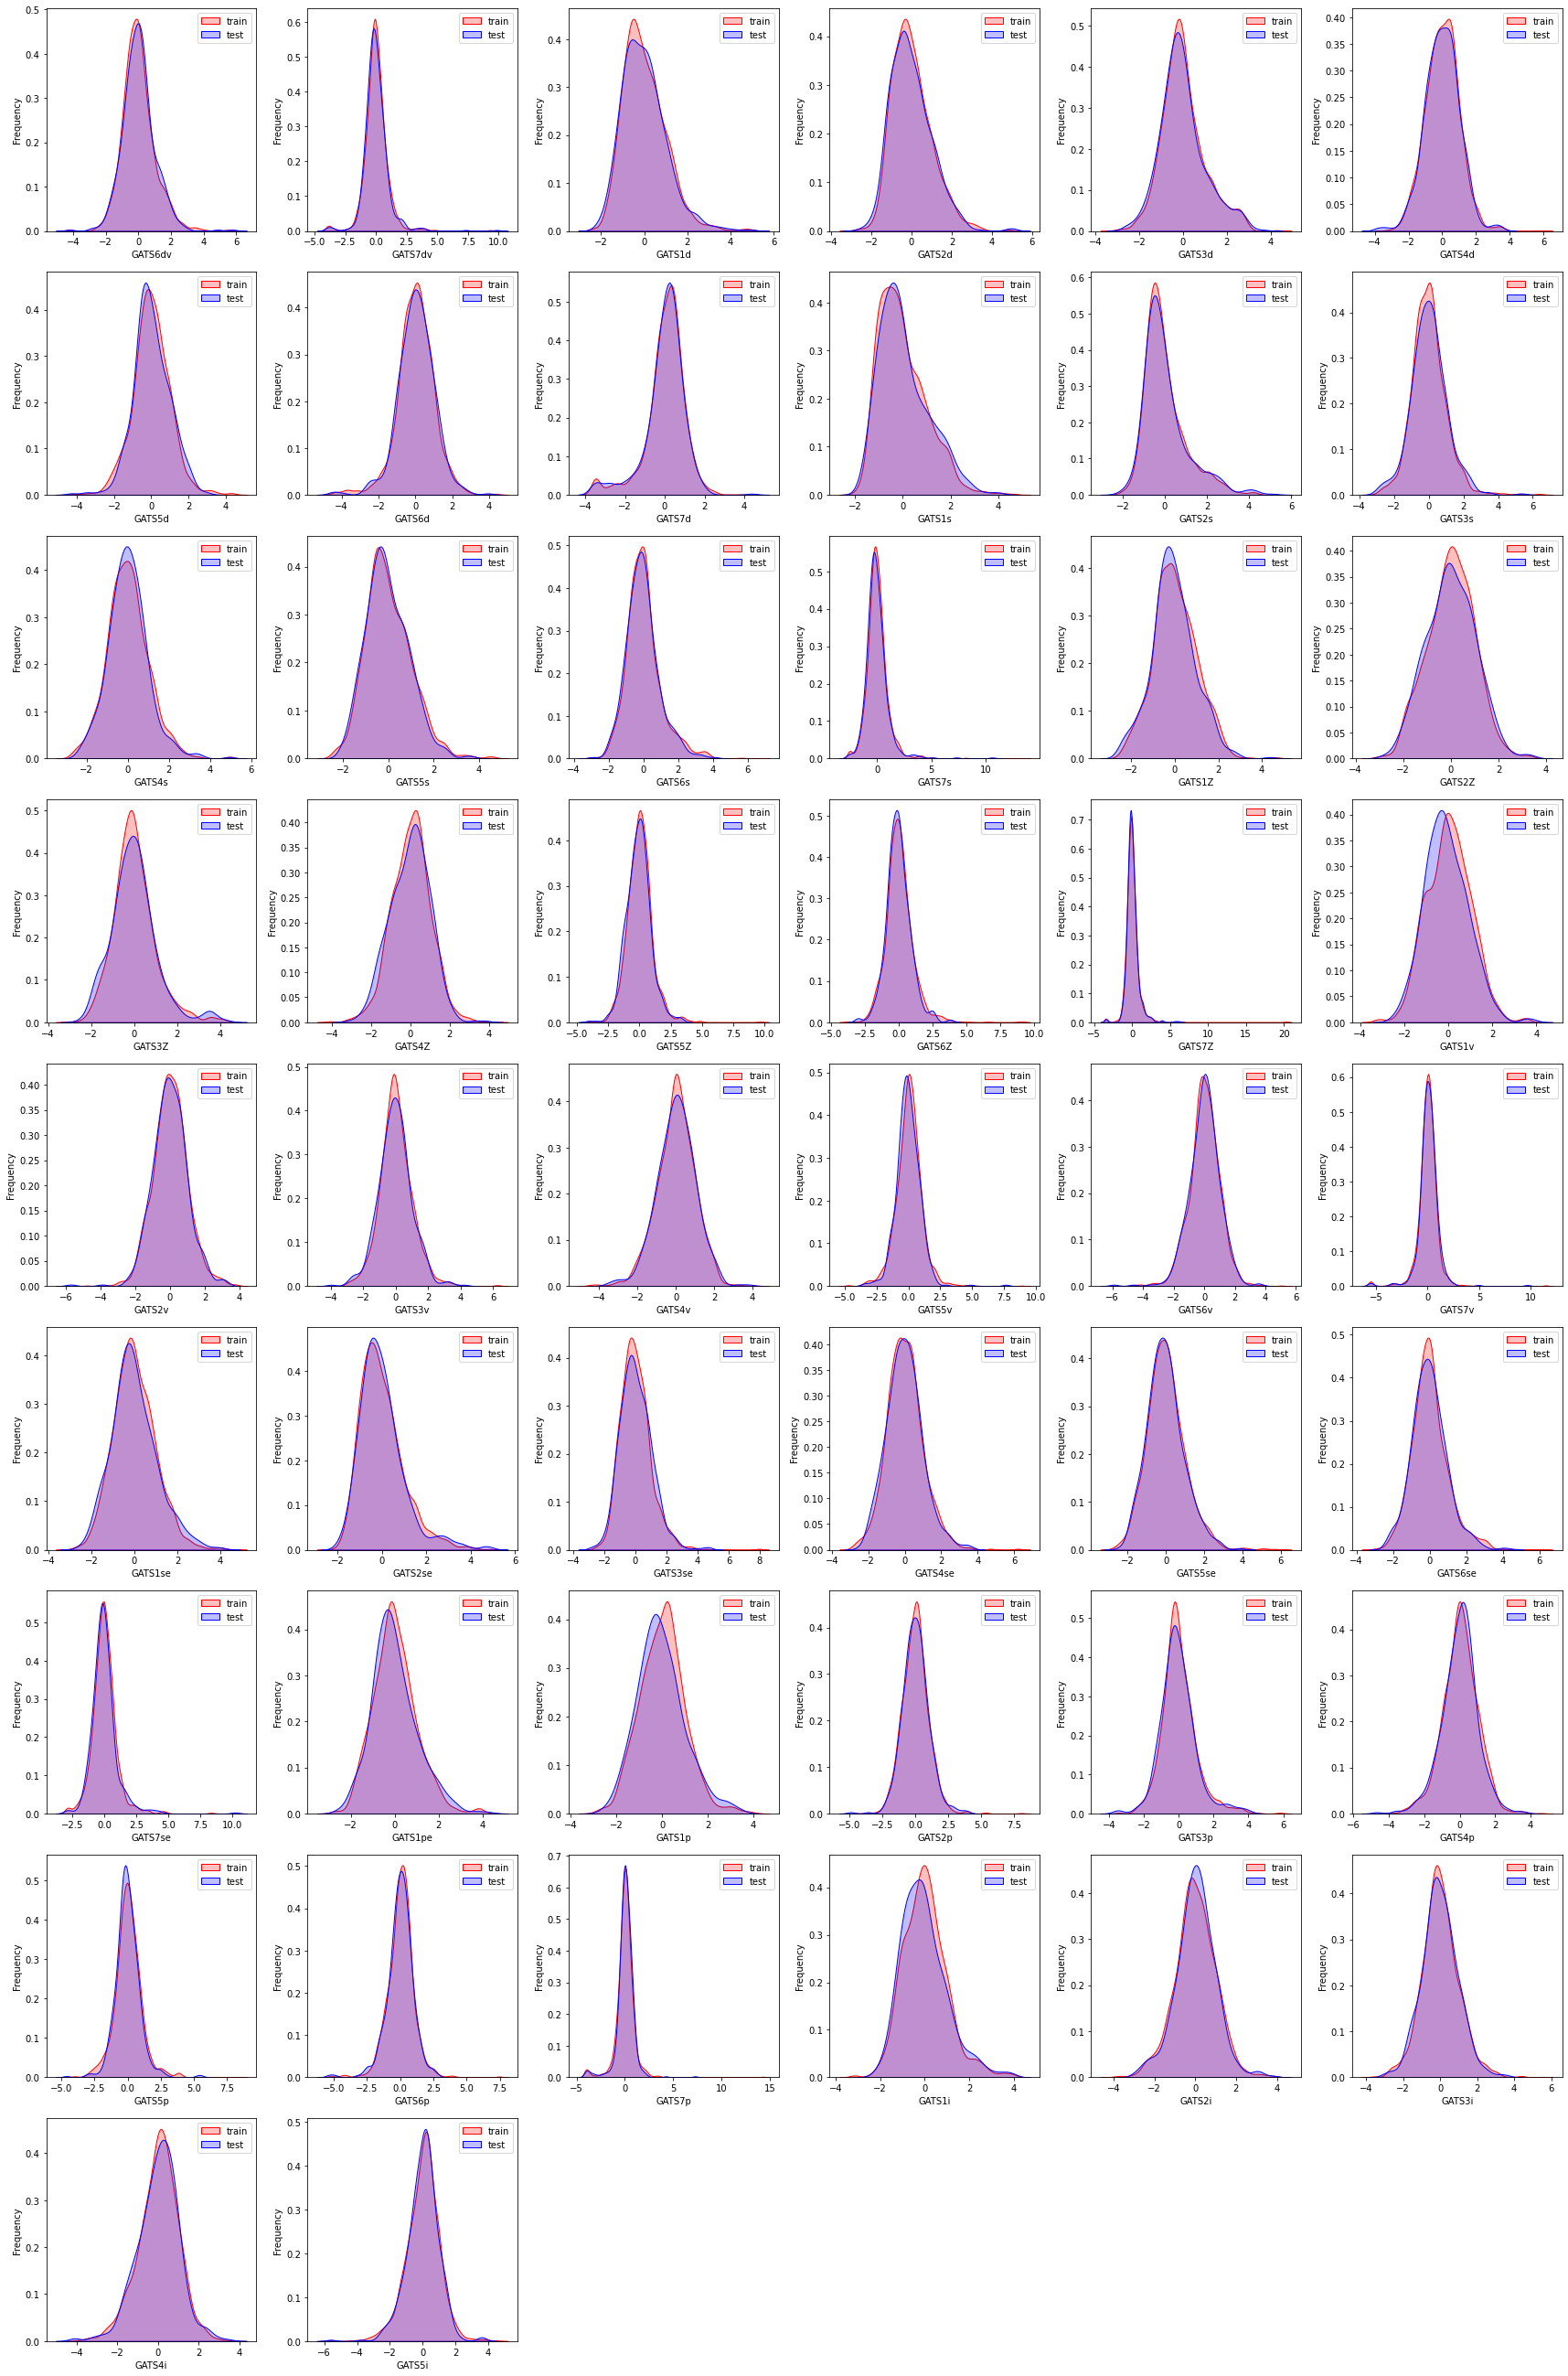

In [20]:
# draw the probability density estimates of the 301-350th features 
# in the training set and test set
train = x_train.loc[:, x_train.columns[301]:x_train.columns[350]]
test = x_test.loc[:, x_test.columns[301]:x_test.columns[350]]
KDE(train, test, "supplemental_fig7.png")

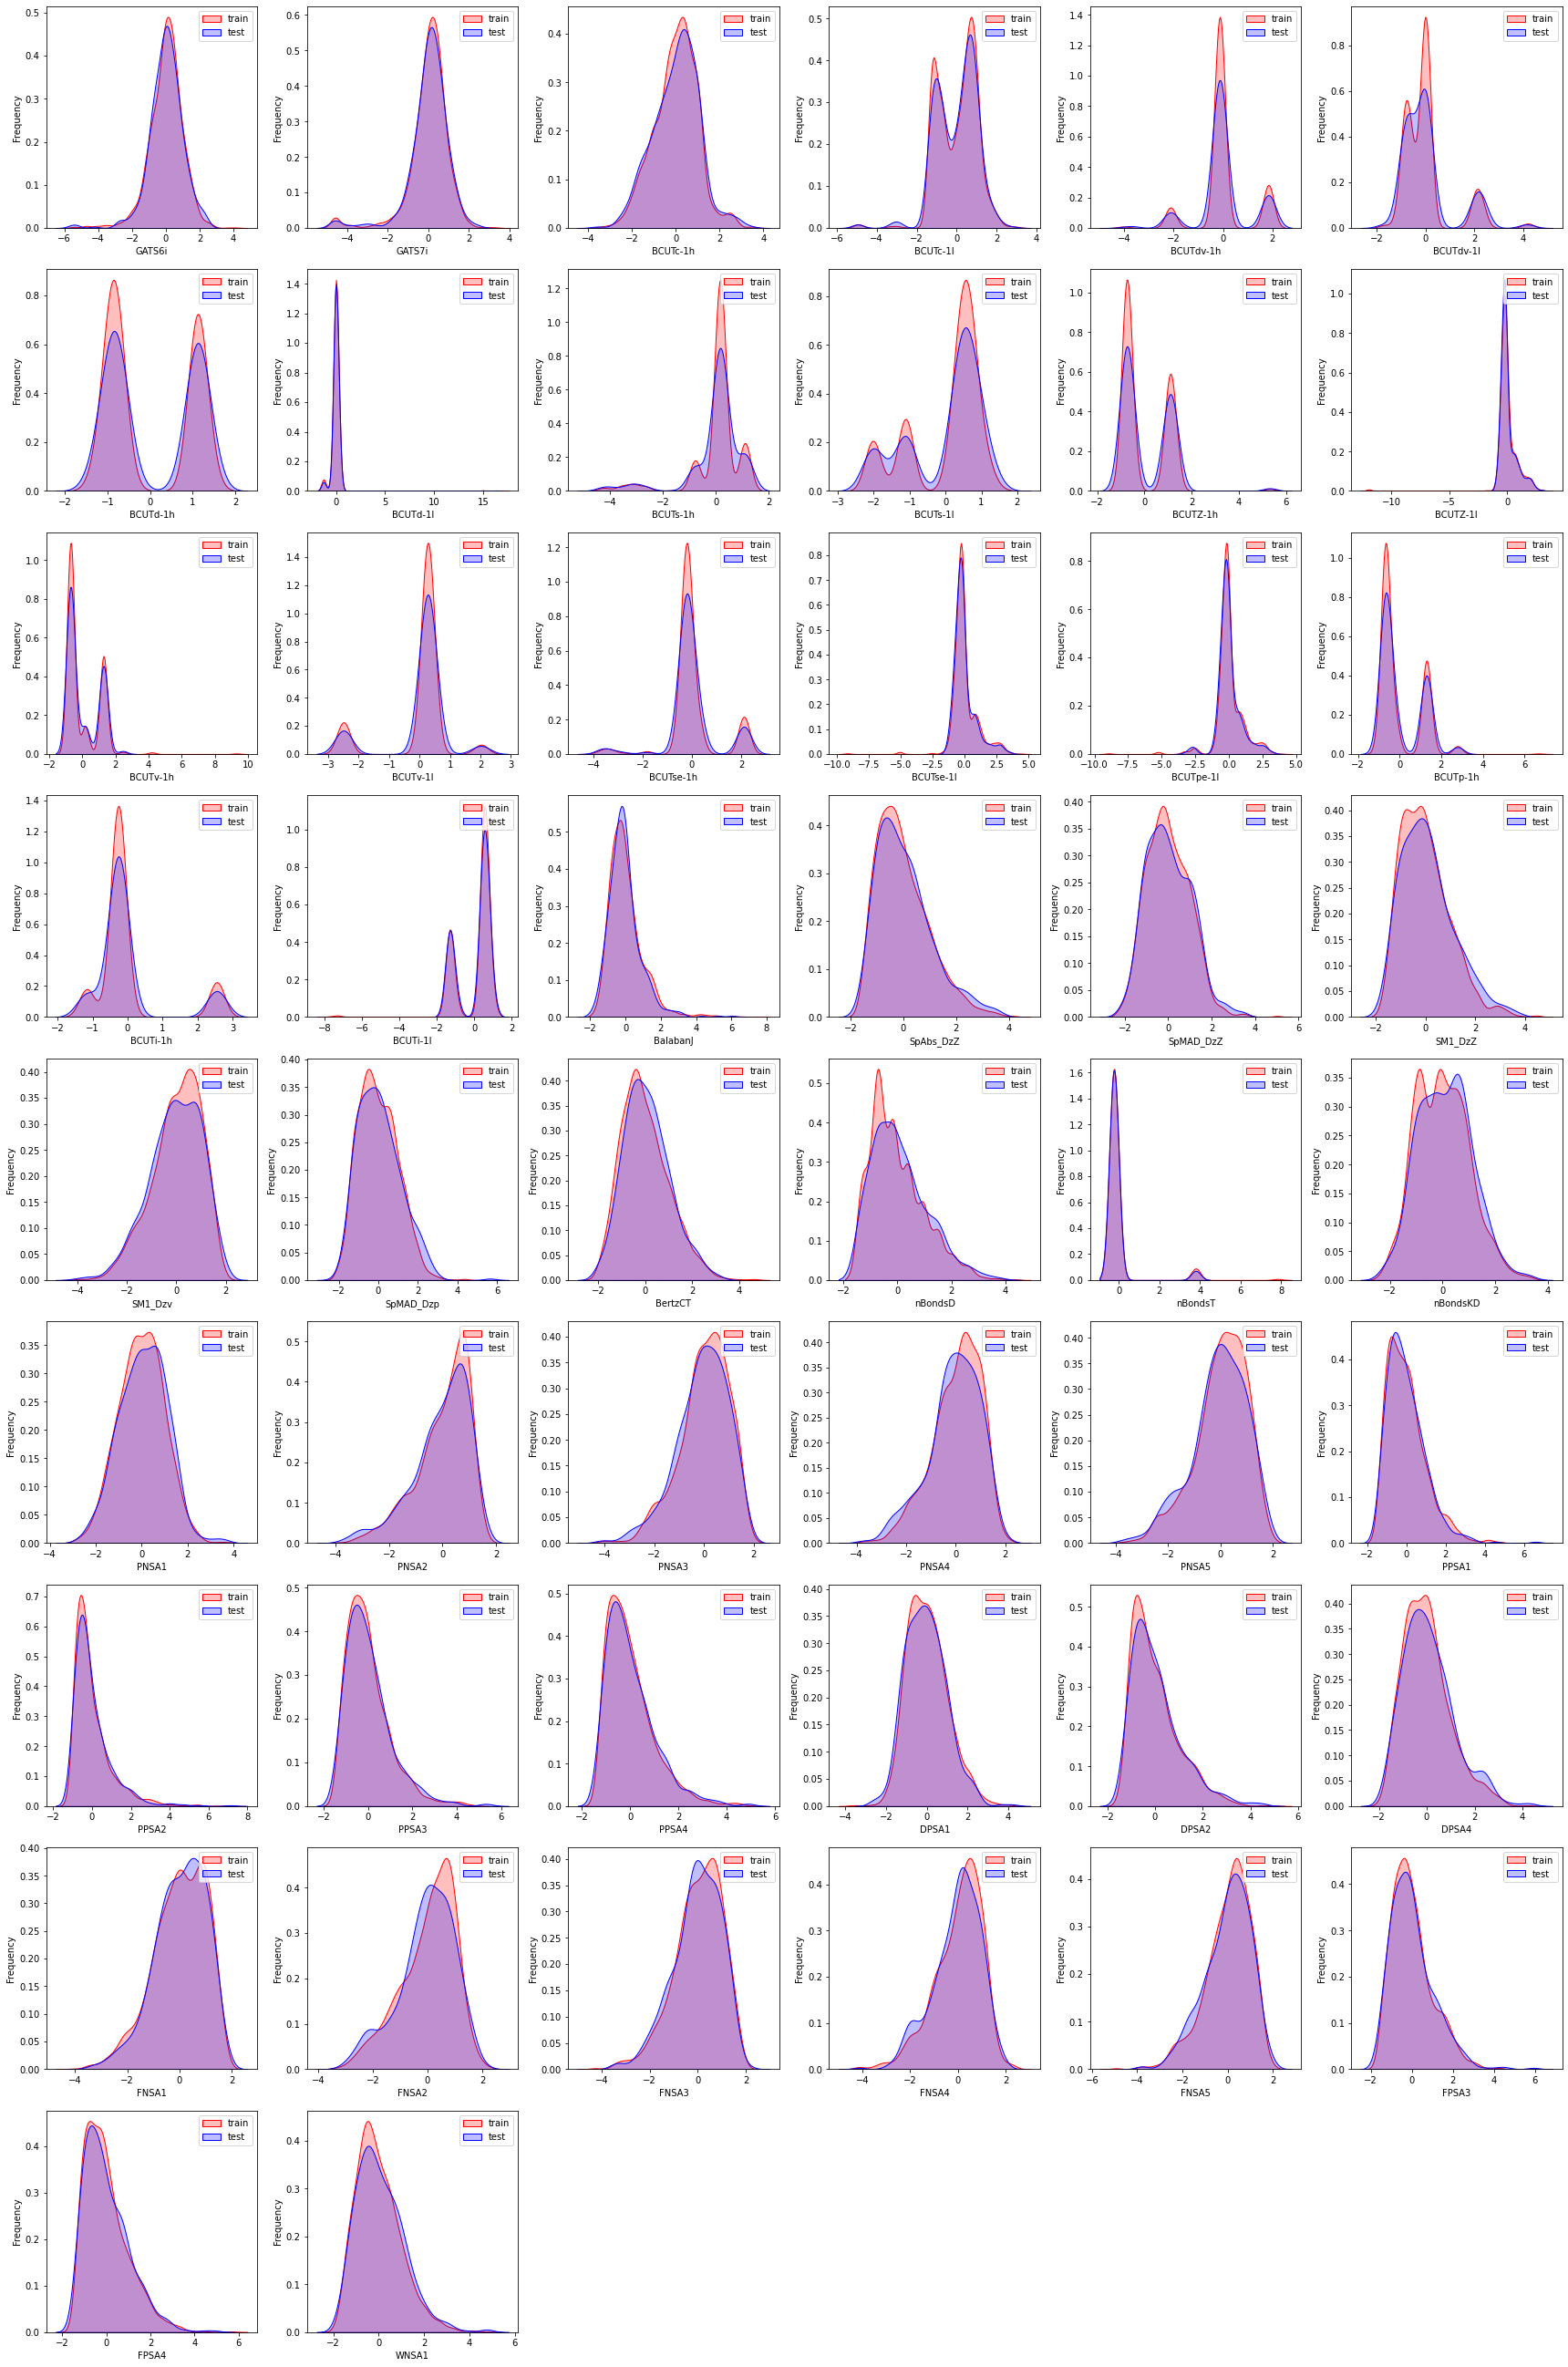

In [21]:
# draw the probability density estimates of the 351-400th features 
# in the training set and test set
train = x_train.loc[:, x_train.columns[351]:x_train.columns[400]]
test = x_test.loc[:, x_test.columns[351]:x_test.columns[400]]
KDE(train, test, "supplemental_fig8.png")

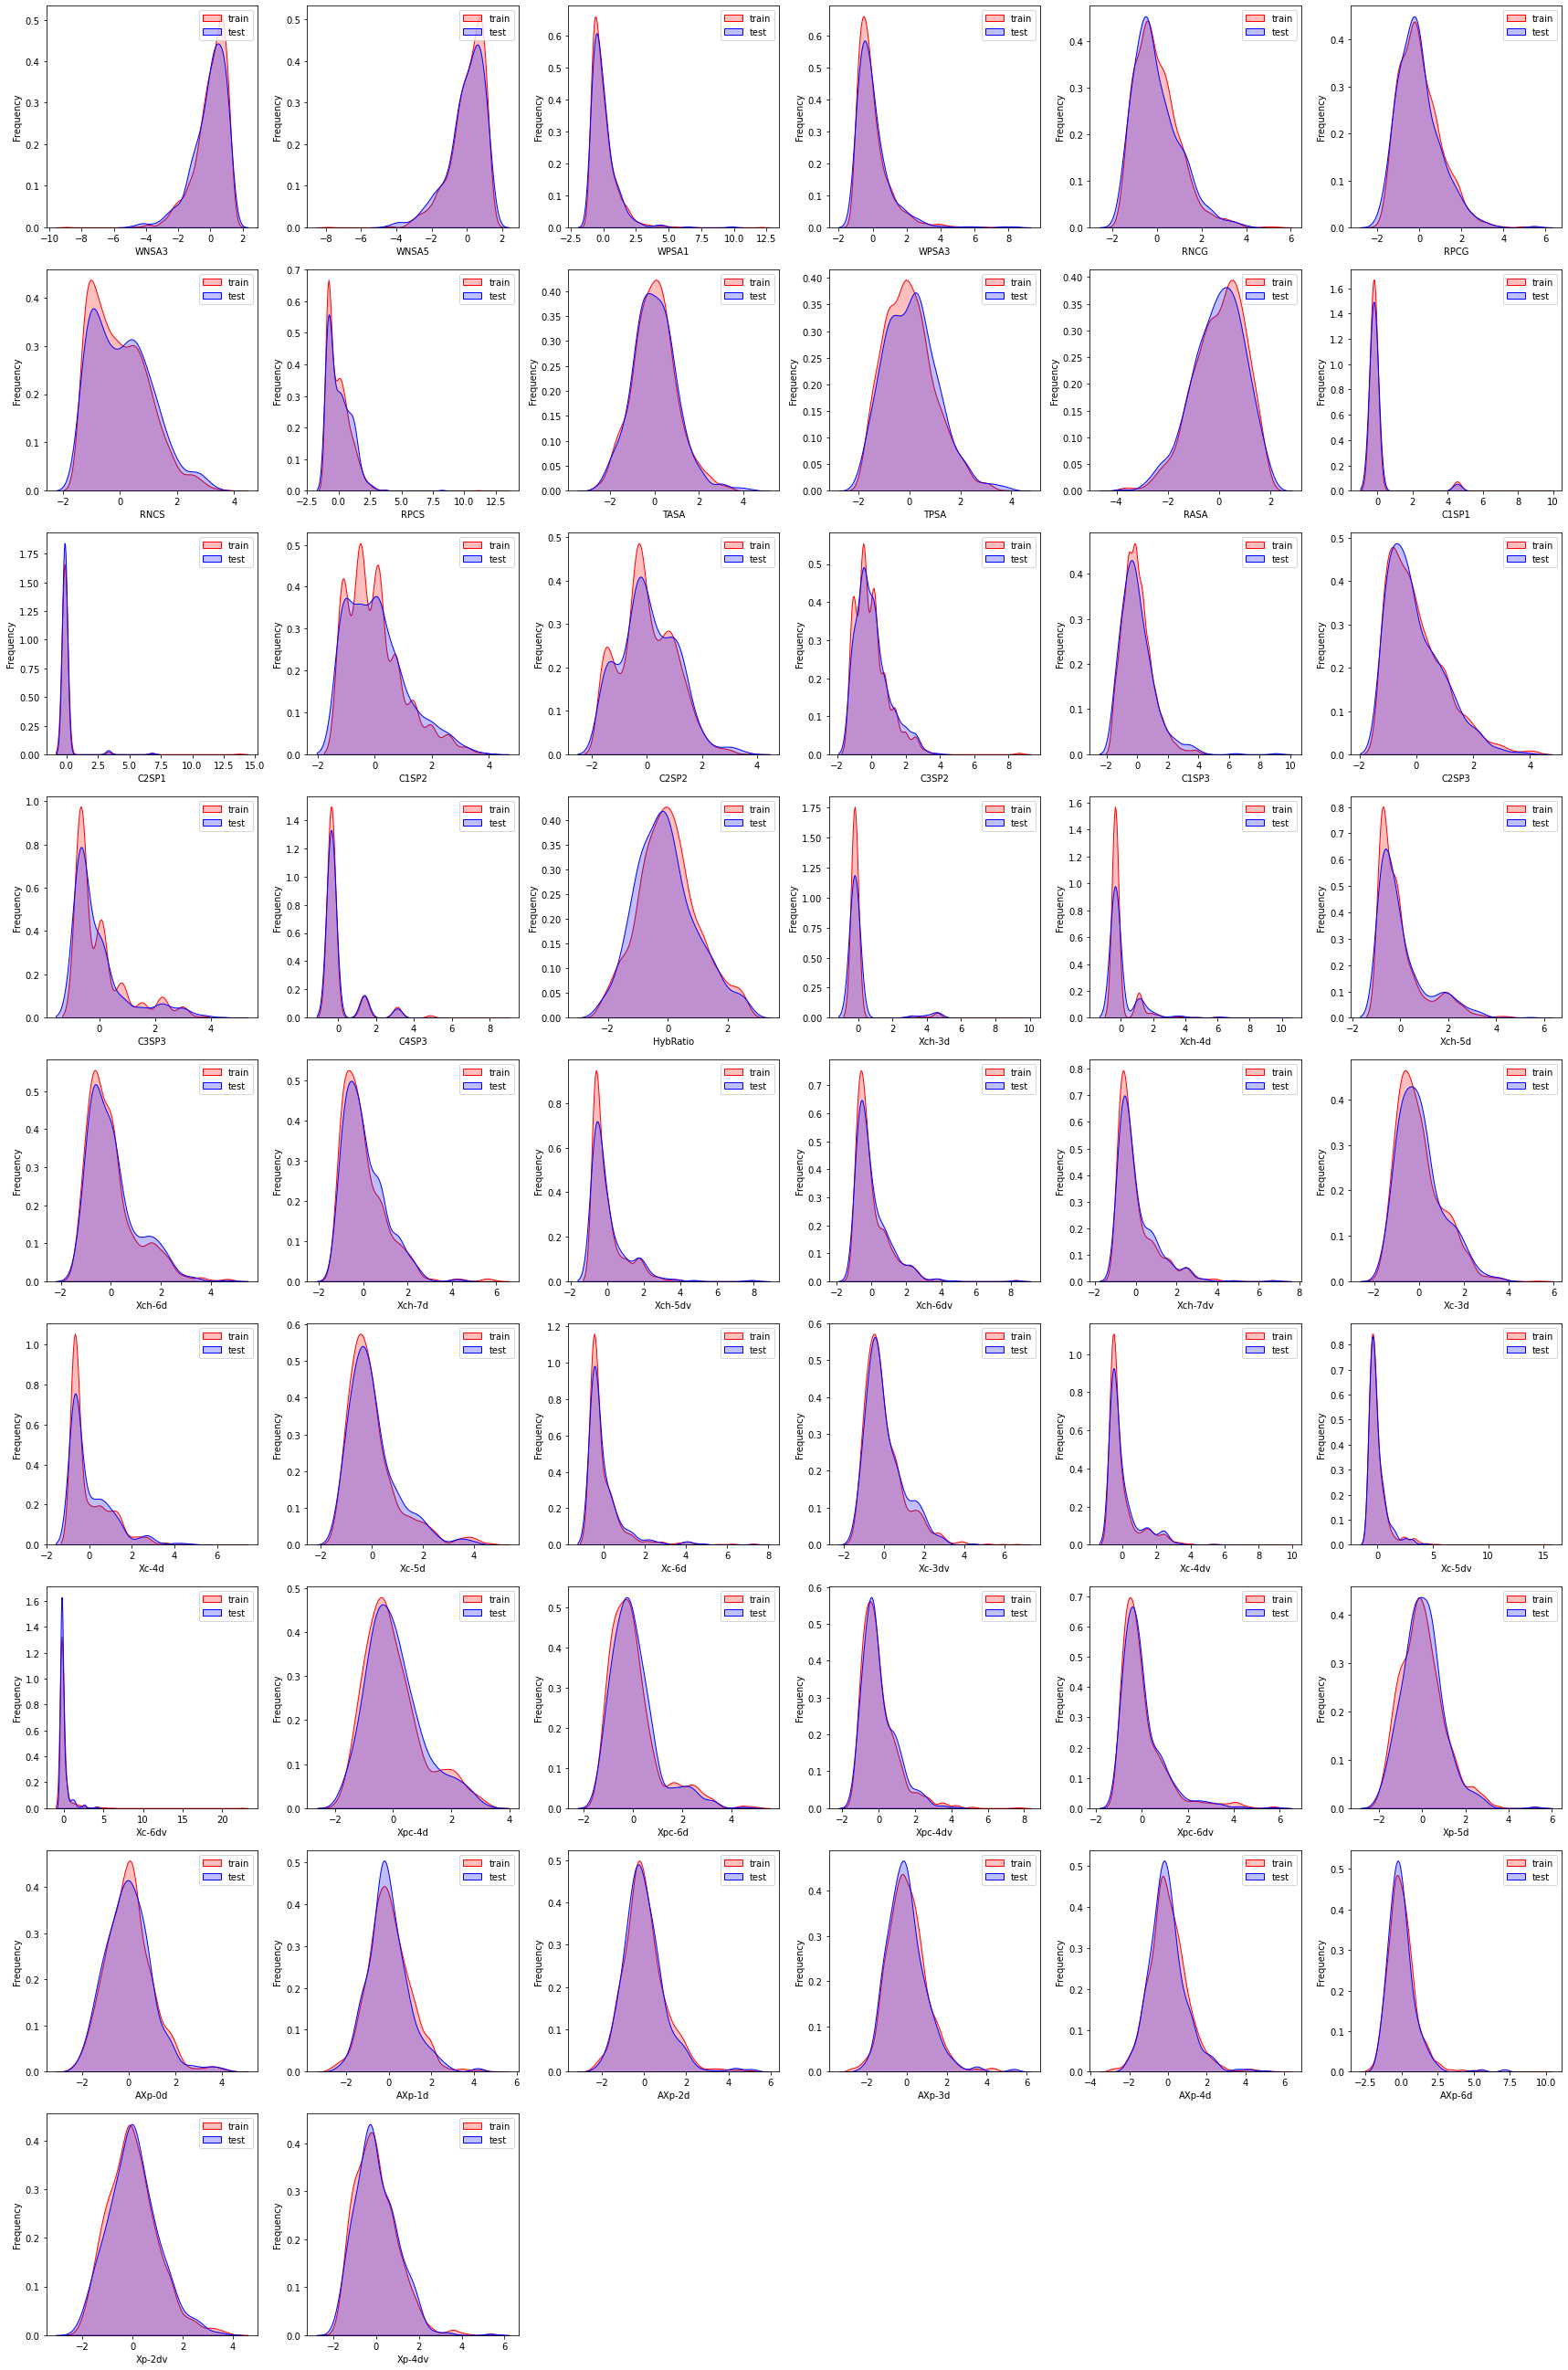

In [22]:
# draw the probability density estimates of the 401-450th features 
# in the training set and test set 
train = x_train.loc[:, x_train.columns[401]:x_train.columns[450]]
test = x_test.loc[:, x_test.columns[401]:x_test.columns[450]]
KDE(train, test, "supplemental_fig9.png")

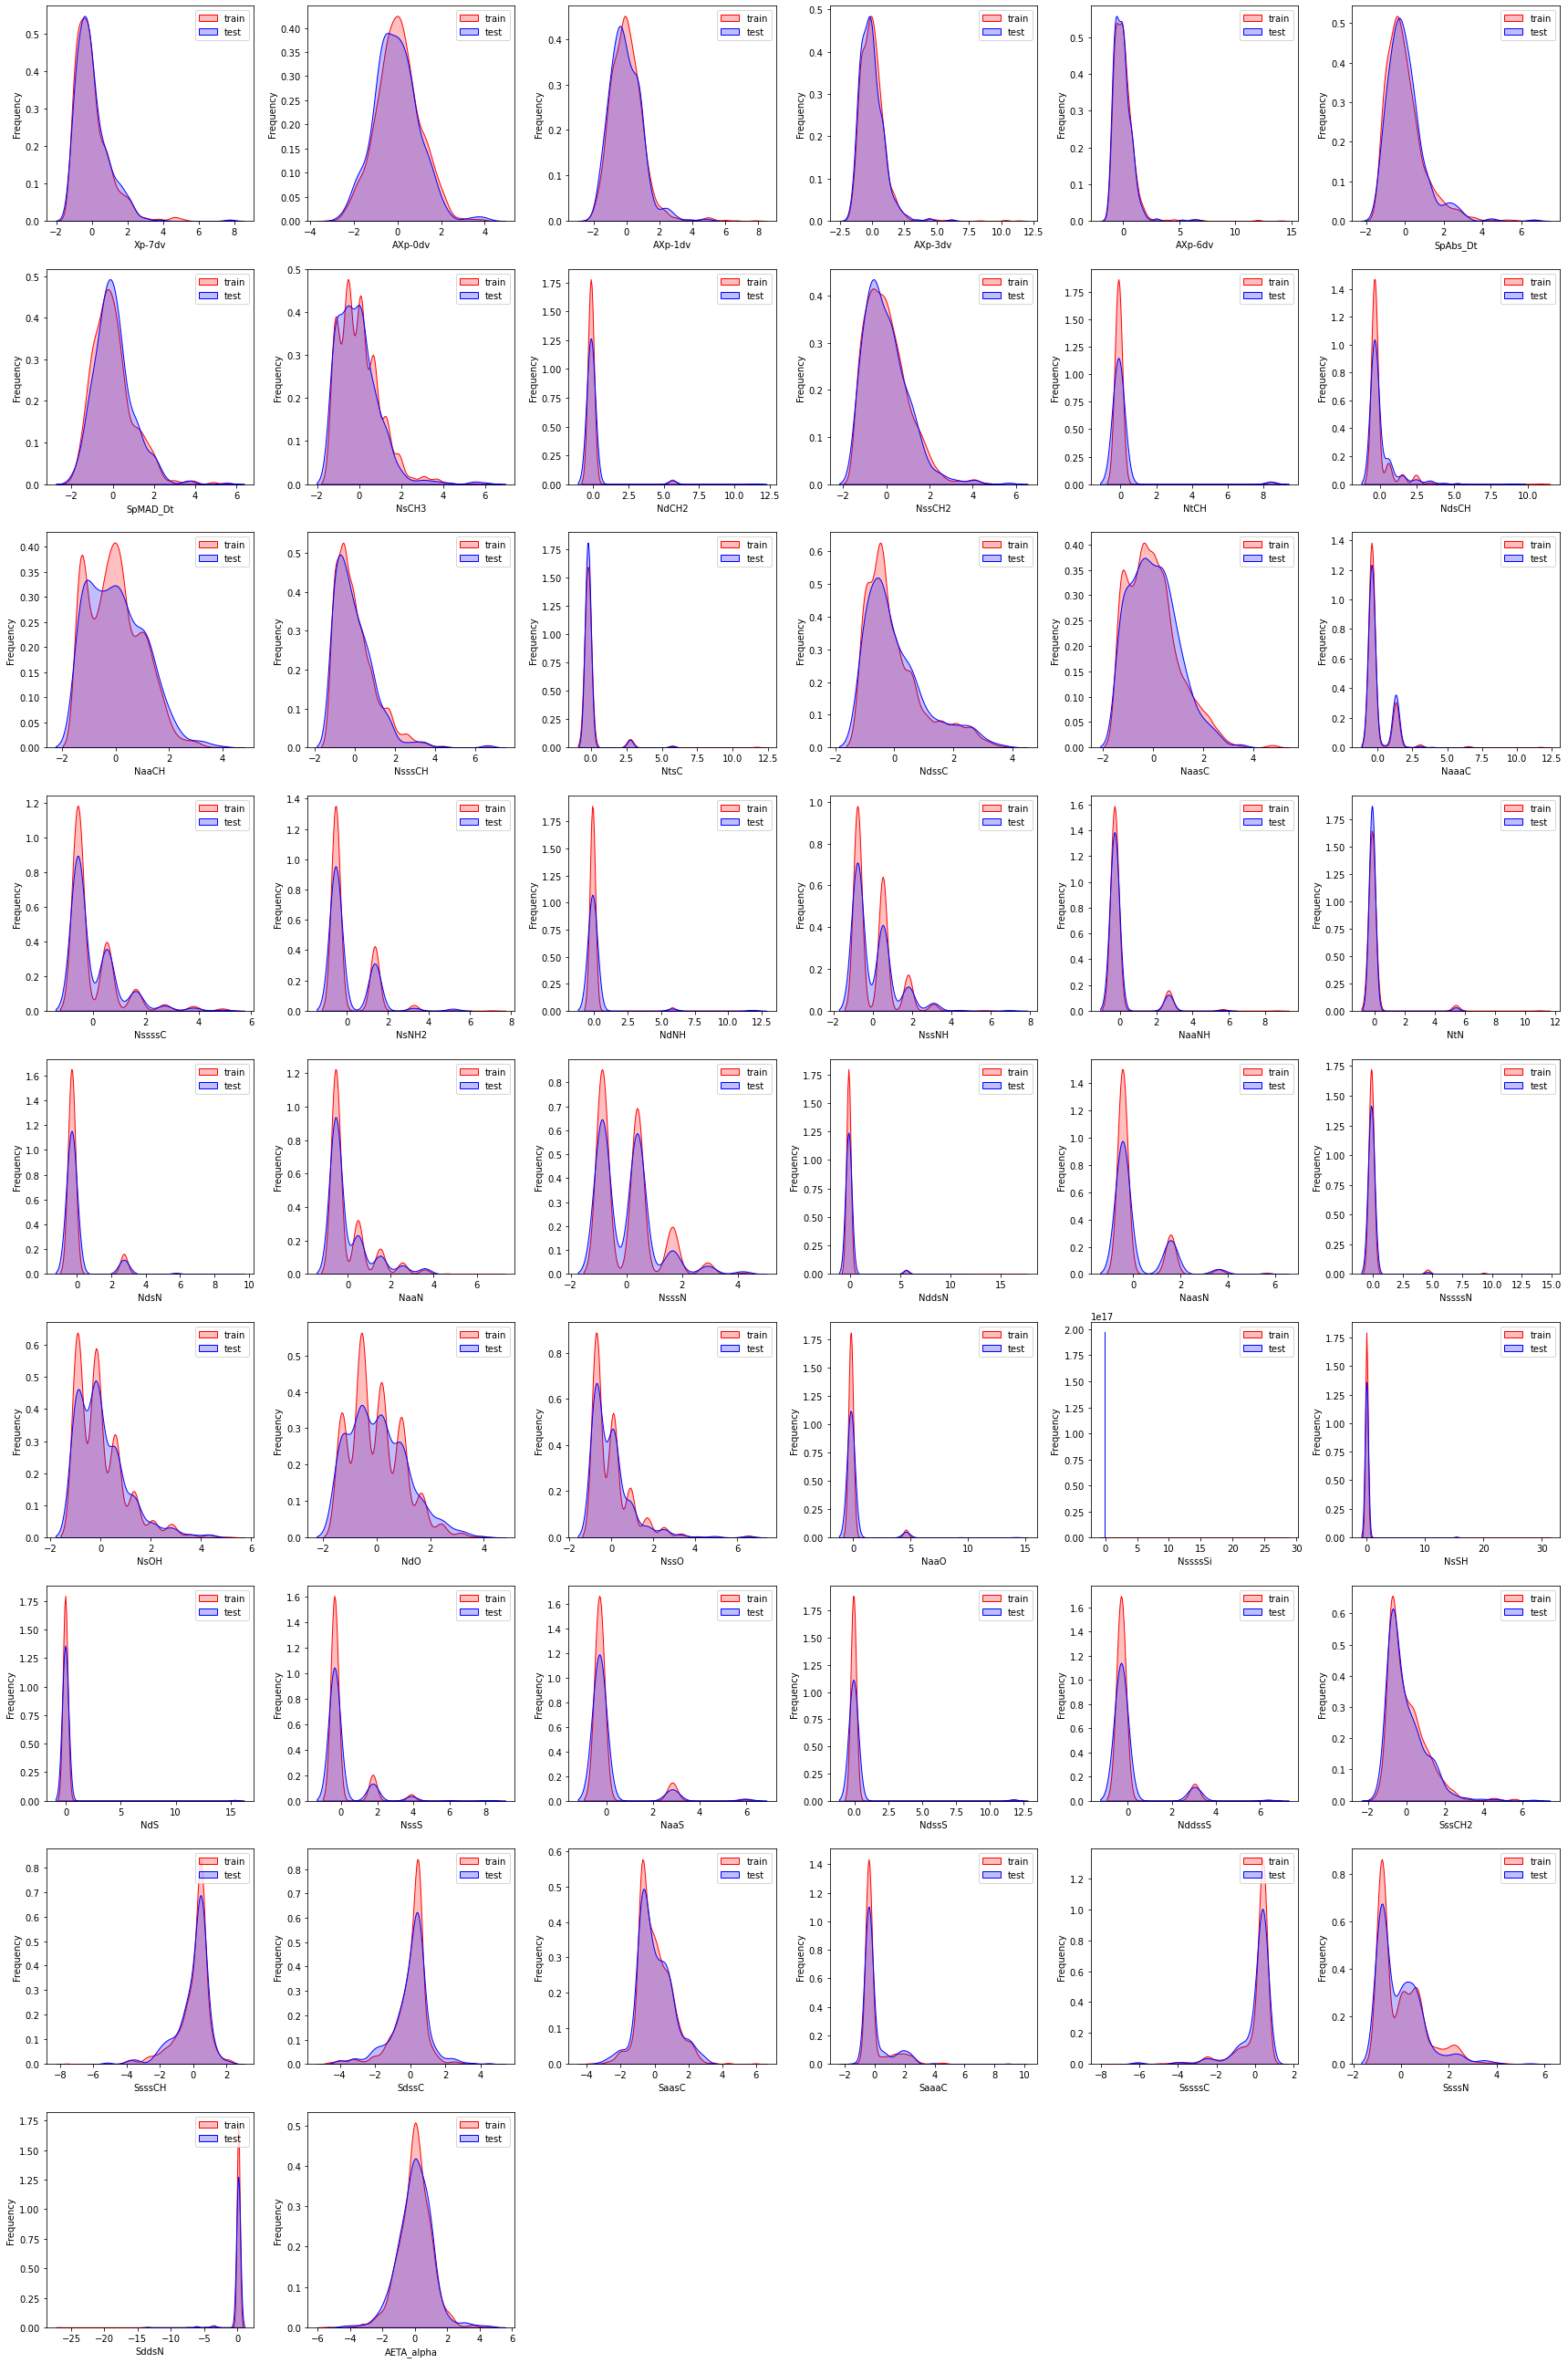

In [23]:
# draw the probability density estimates of the 451-500th features 
# in the training set and test set
train = x_train.loc[:, x_train.columns[451]:x_train.columns[500]]
test = x_test.loc[:, x_test.columns[451]:x_test.columns[500]]
KDE(train, test, "supplemental_fig10.png")

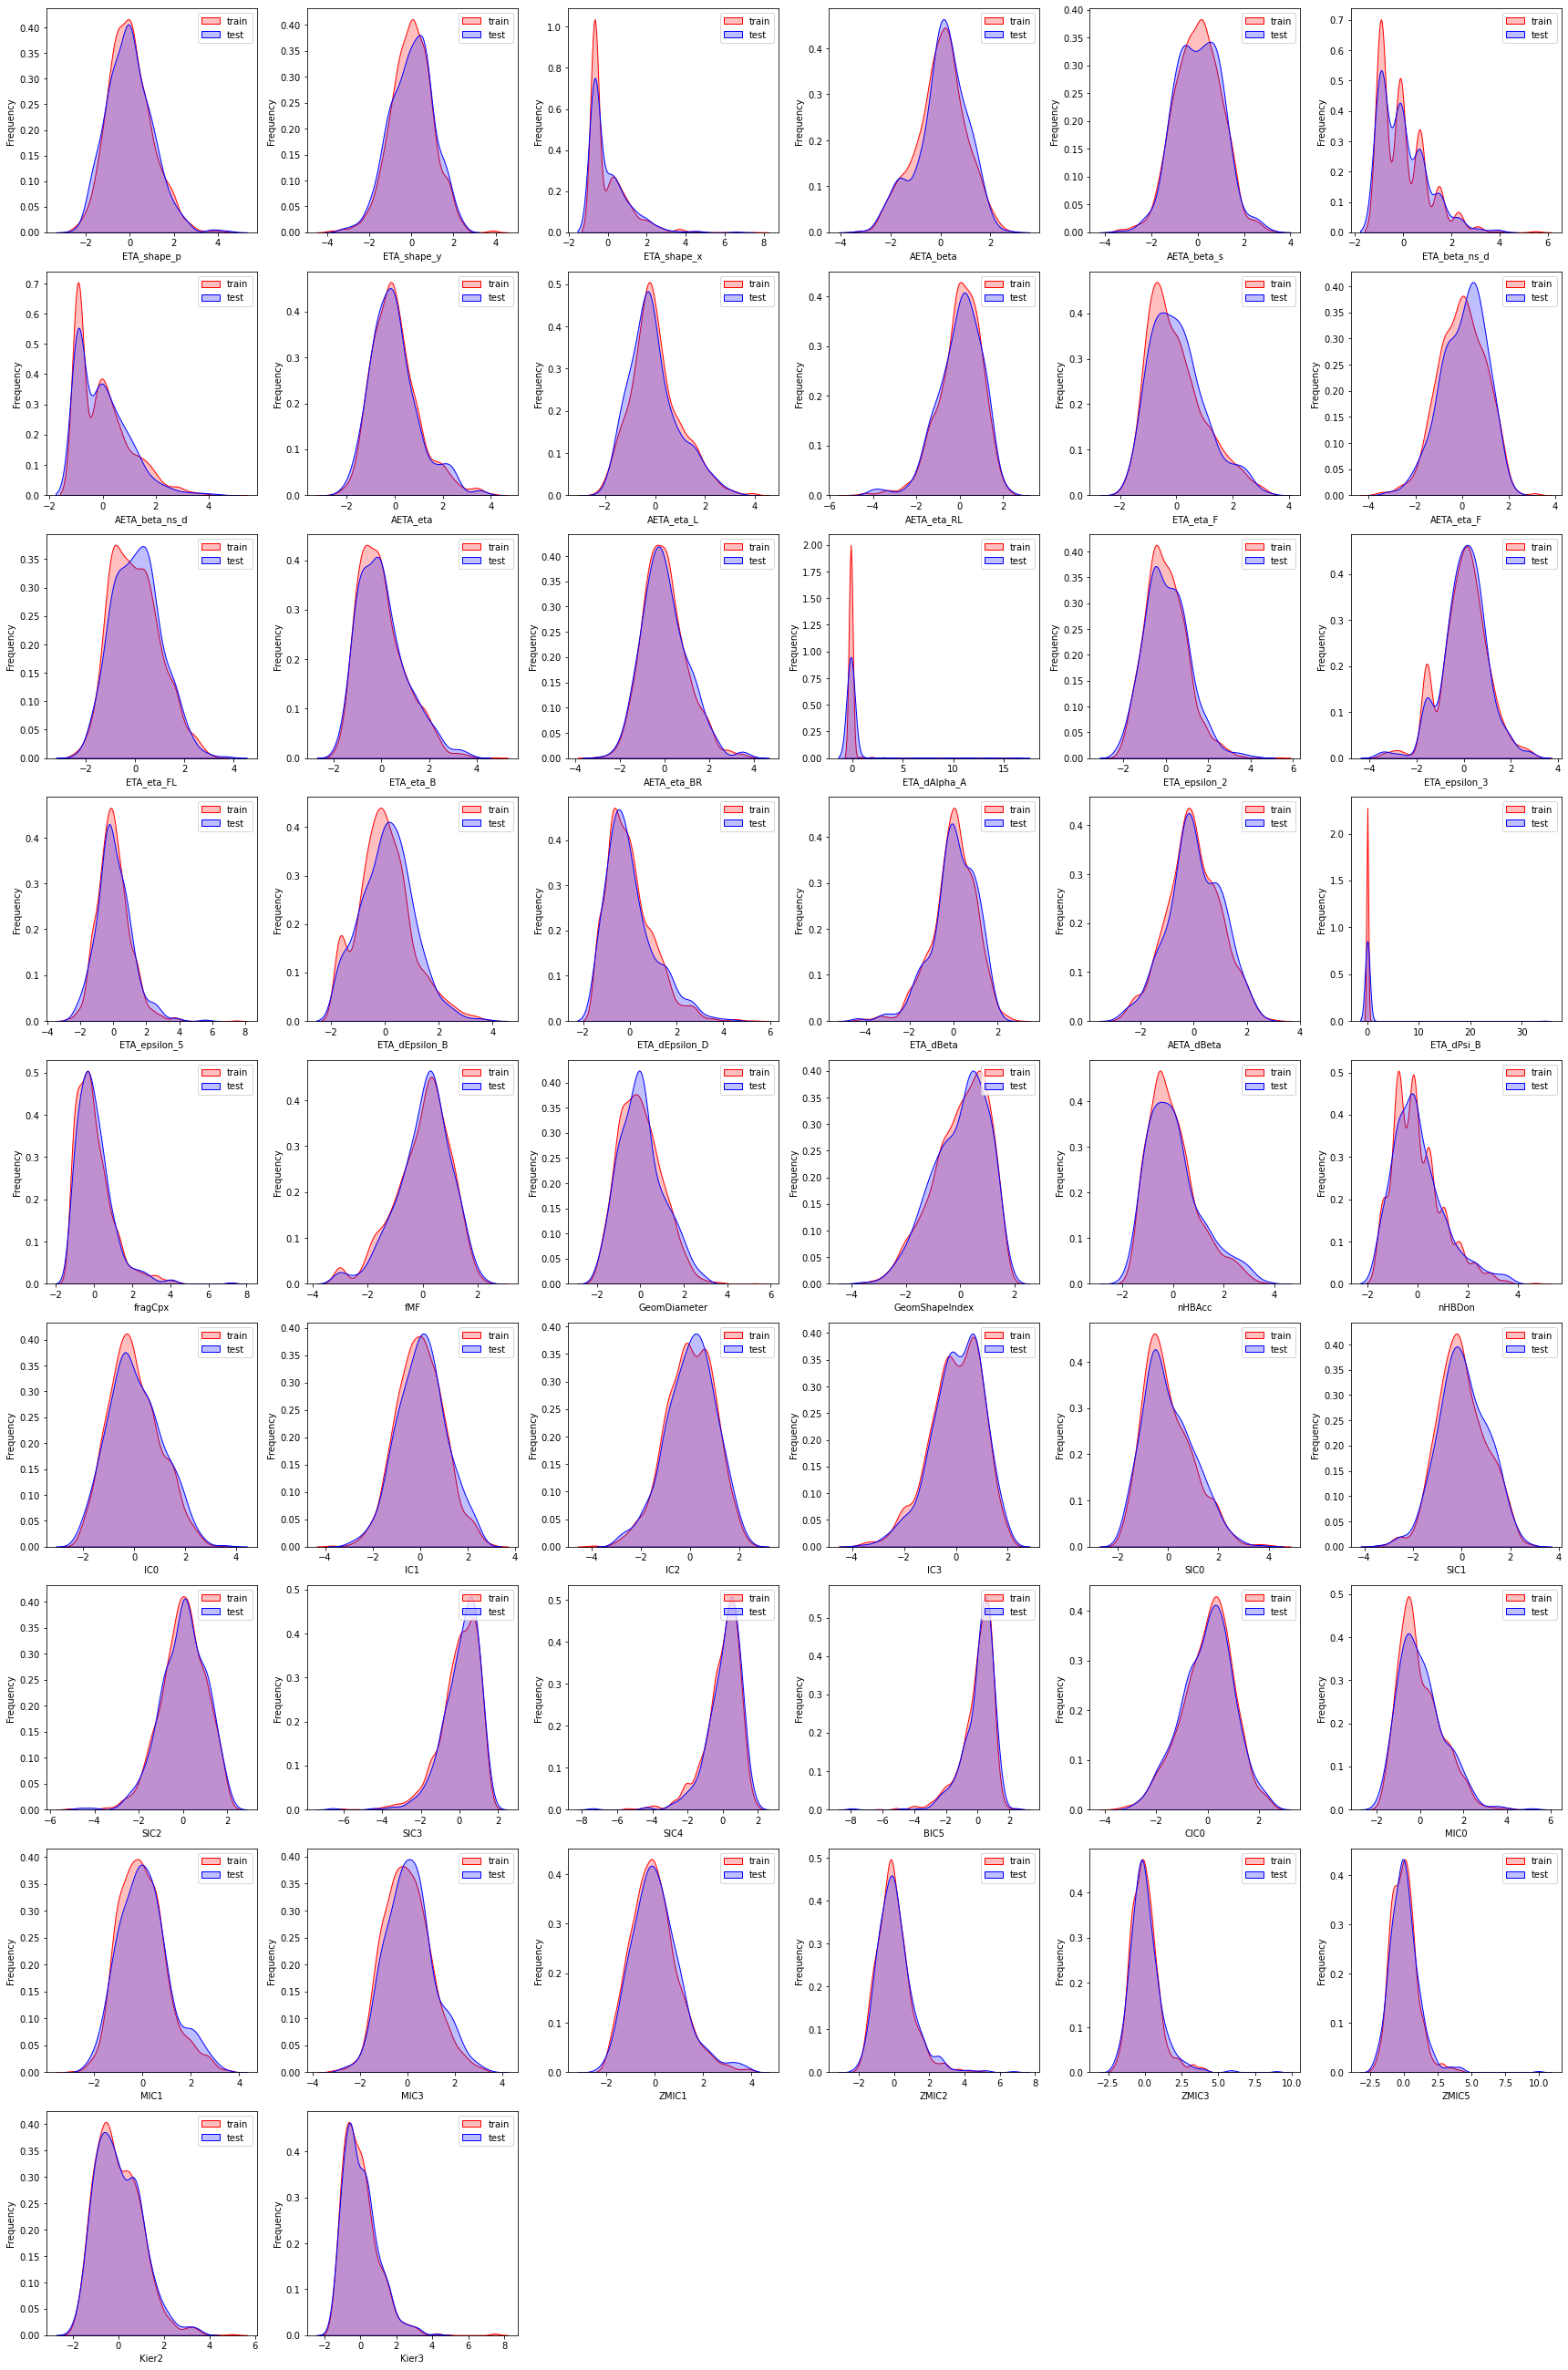

In [24]:
# draw the probability density estimates of the 501-550th features 
# in the training set and test set
train = x_train.loc[:, x_train.columns[501]:x_train.columns[550]]
test = x_test.loc[:, x_test.columns[501]:x_test.columns[550]]
KDE(train, test, "supplemental_fig11.png")

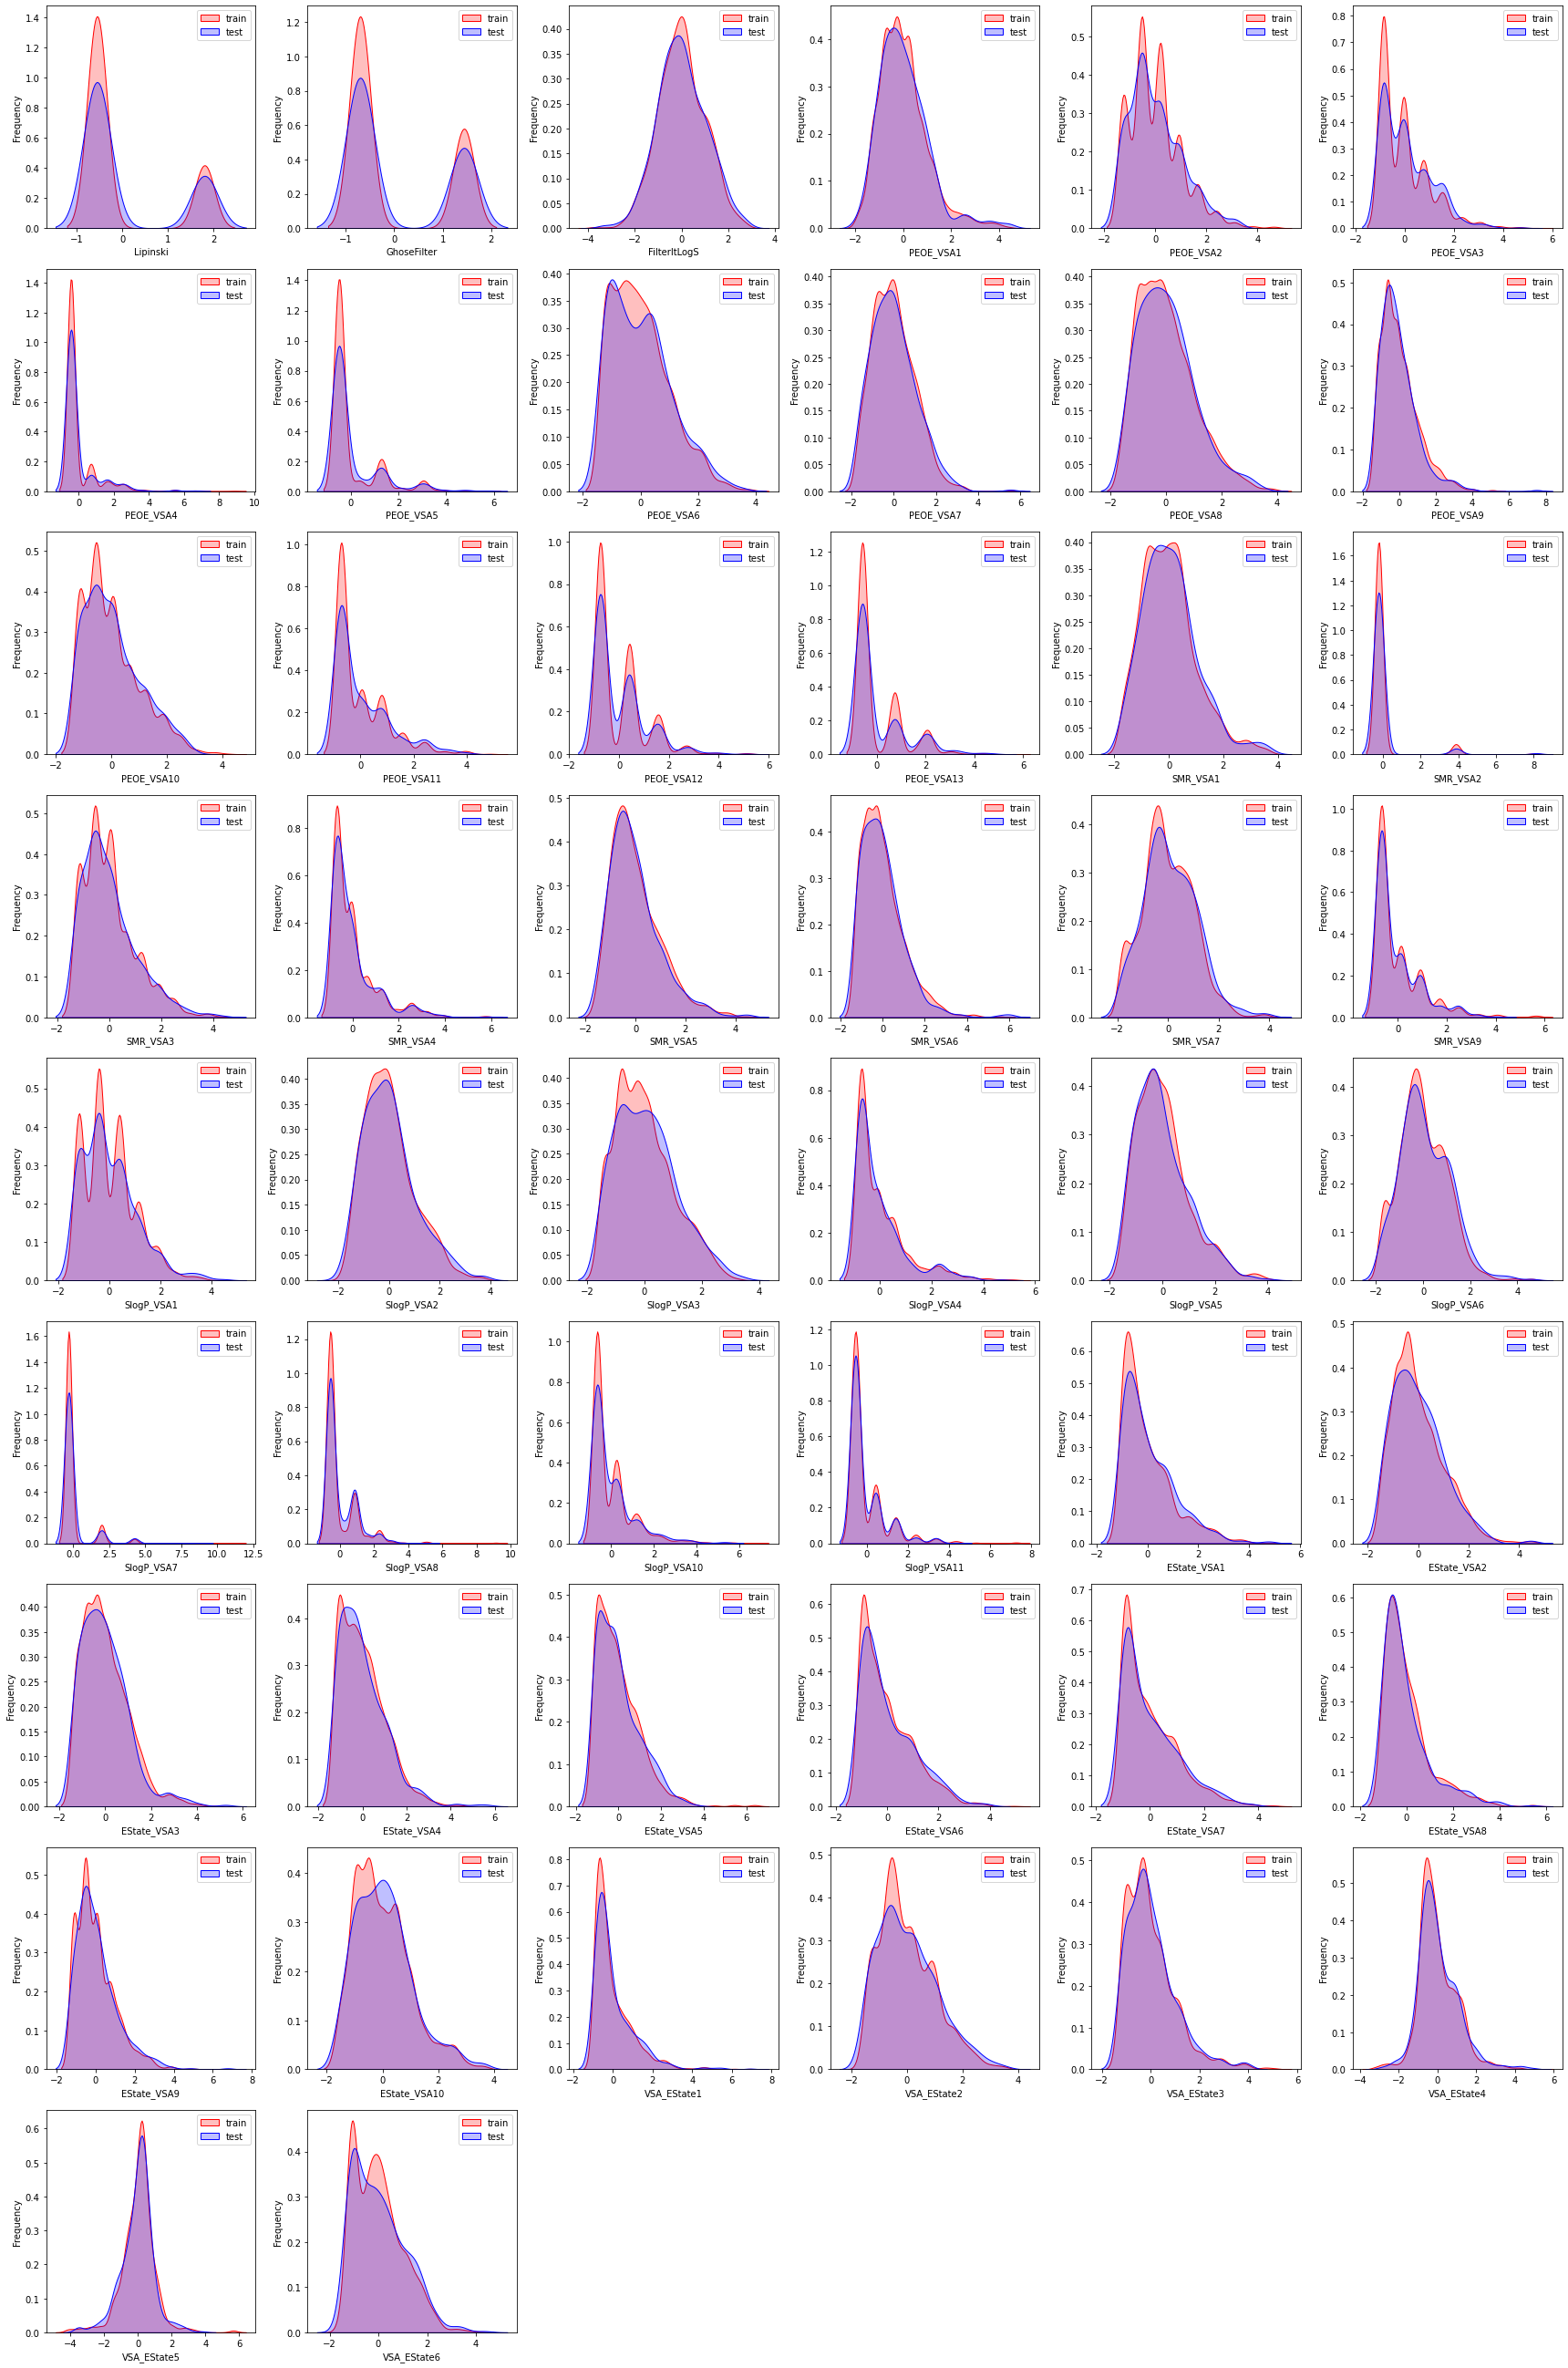

In [25]:
# draw the probability density estimates of the 551-600th features 
# in the training set and test set
train = x_train.loc[:, x_train.columns[551]:x_train.columns[600]]
test = x_test.loc[:, x_test.columns[551]:x_test.columns[600]]
KDE(train, test, "supplemental_fig12.png")

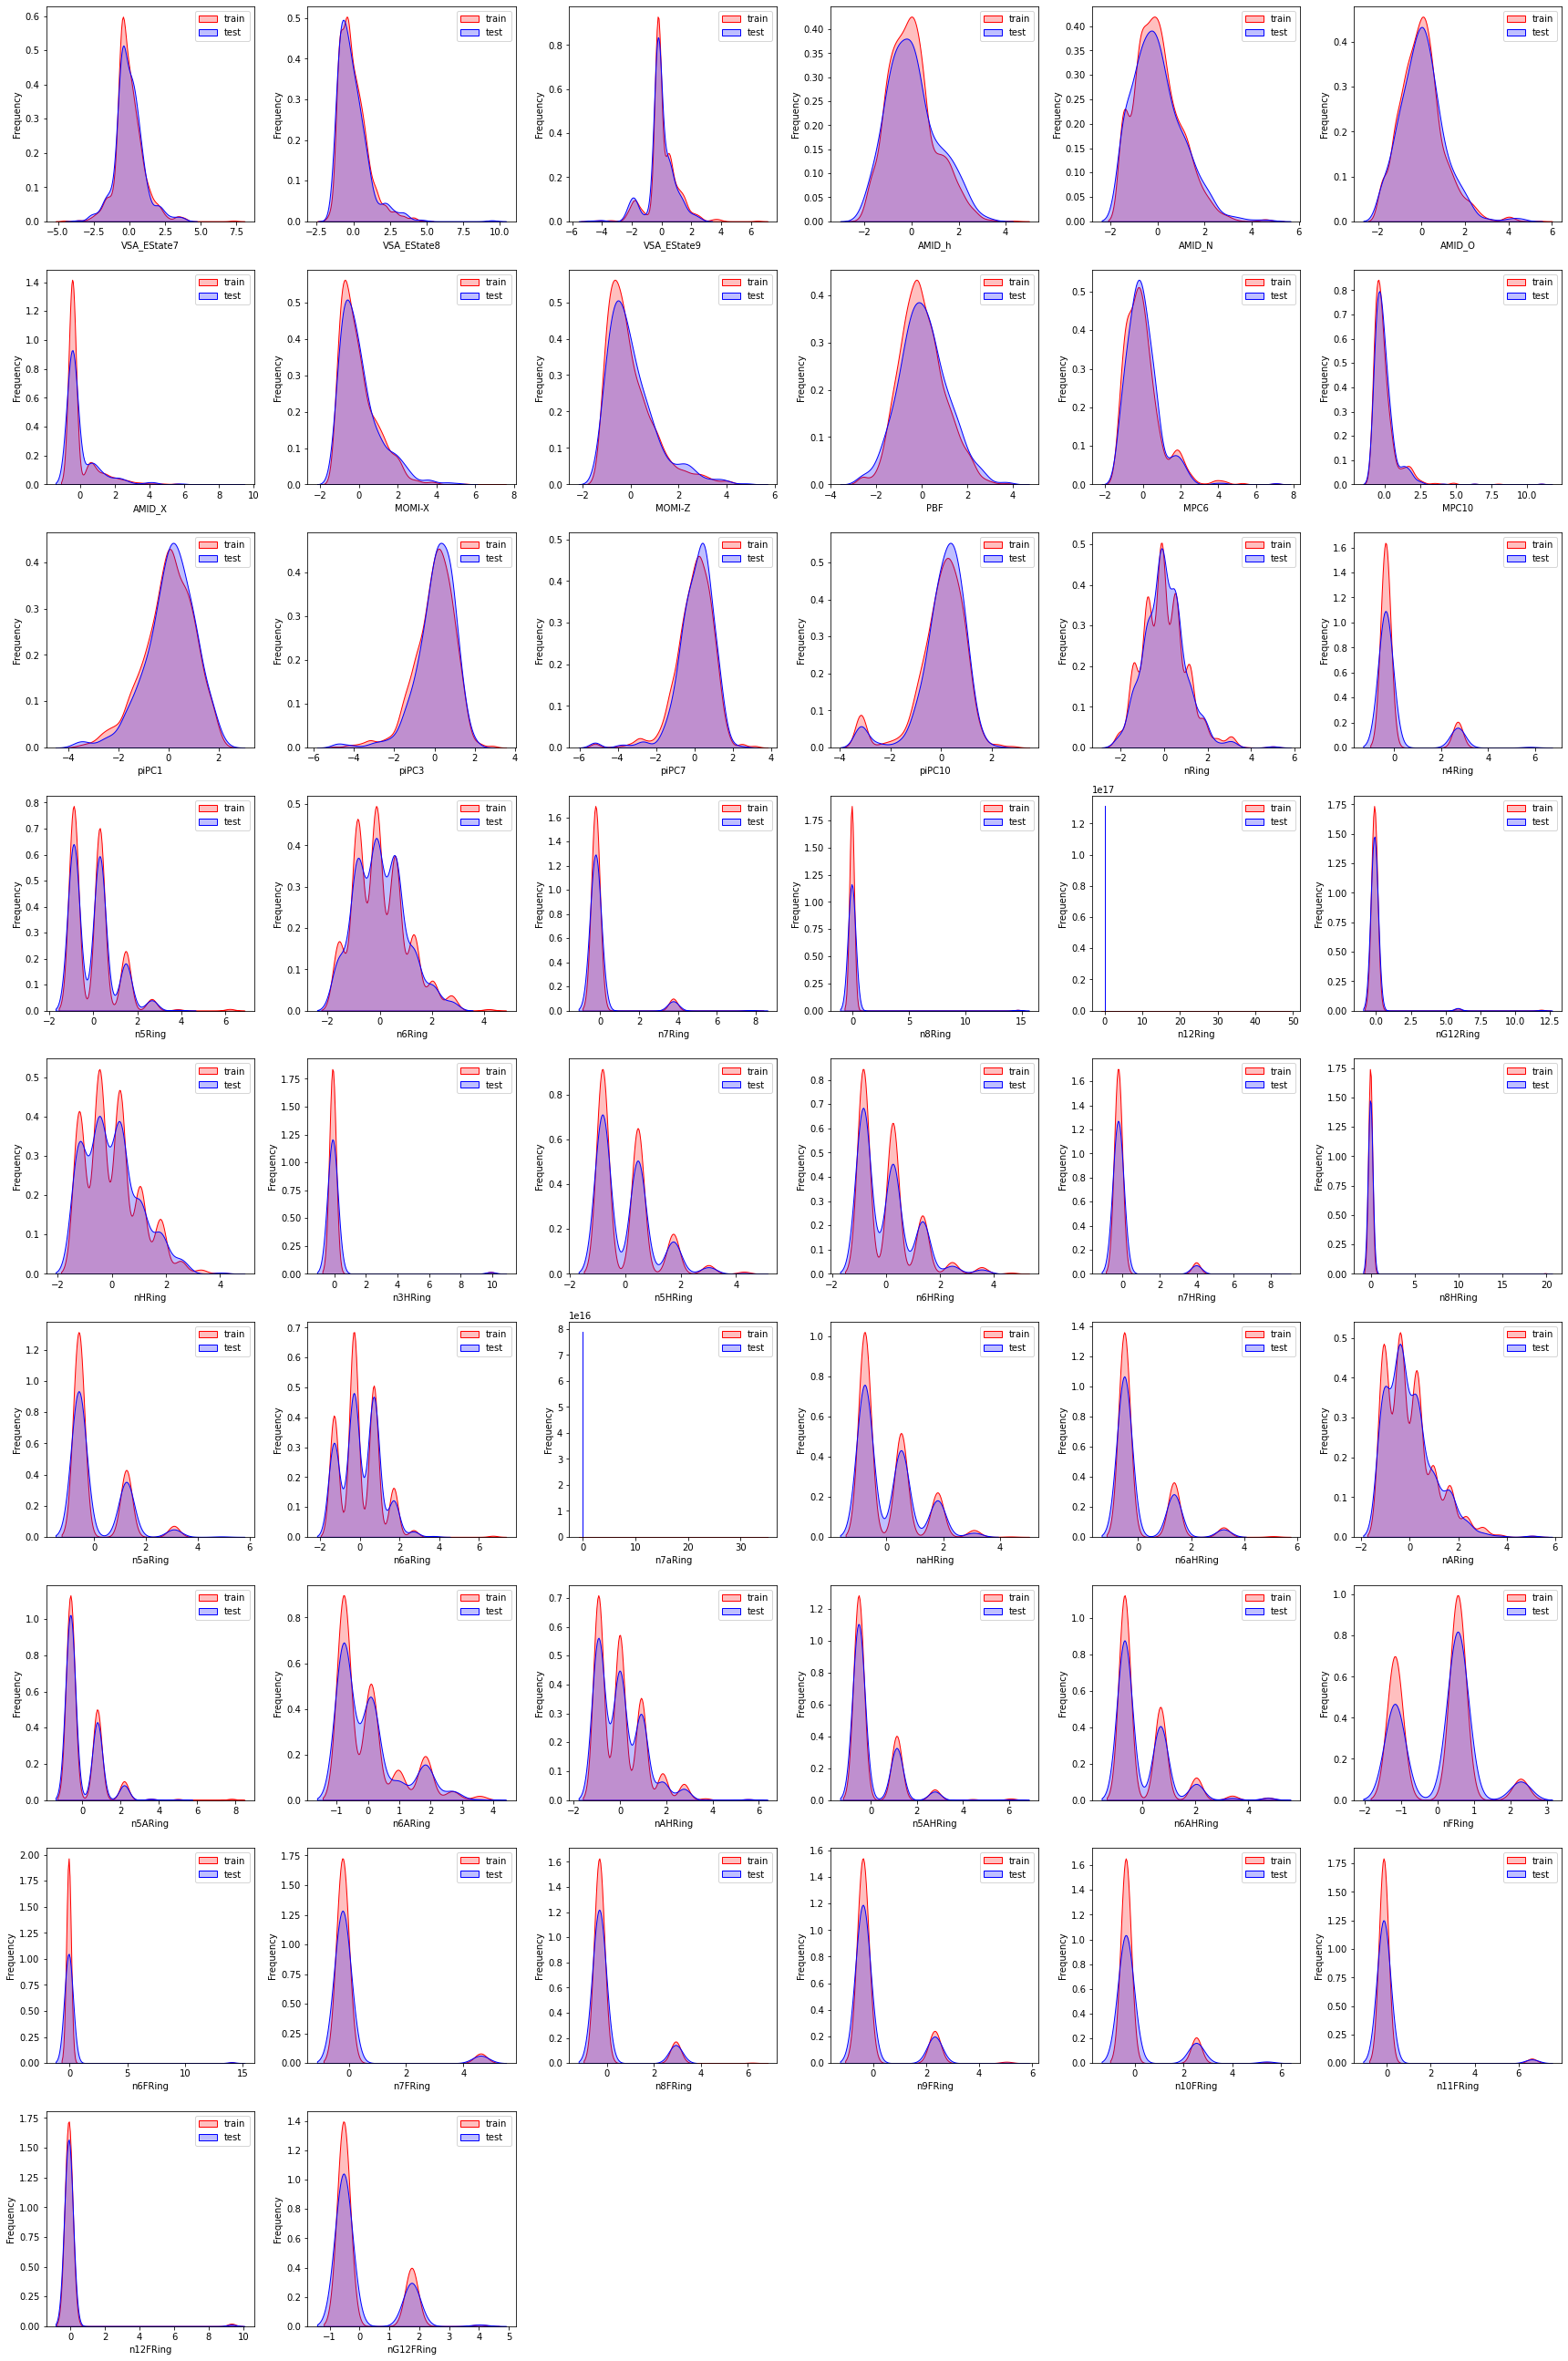

In [26]:
# draw the probability density estimates of the 601-650th features 
# in the training set and test set
train = x_train.loc[:, x_train.columns[601]:x_train.columns[650]]
test = x_test.loc[:, x_test.columns[601]:x_test.columns[650]]
KDE(train, test, "supplemental_fig13.png")

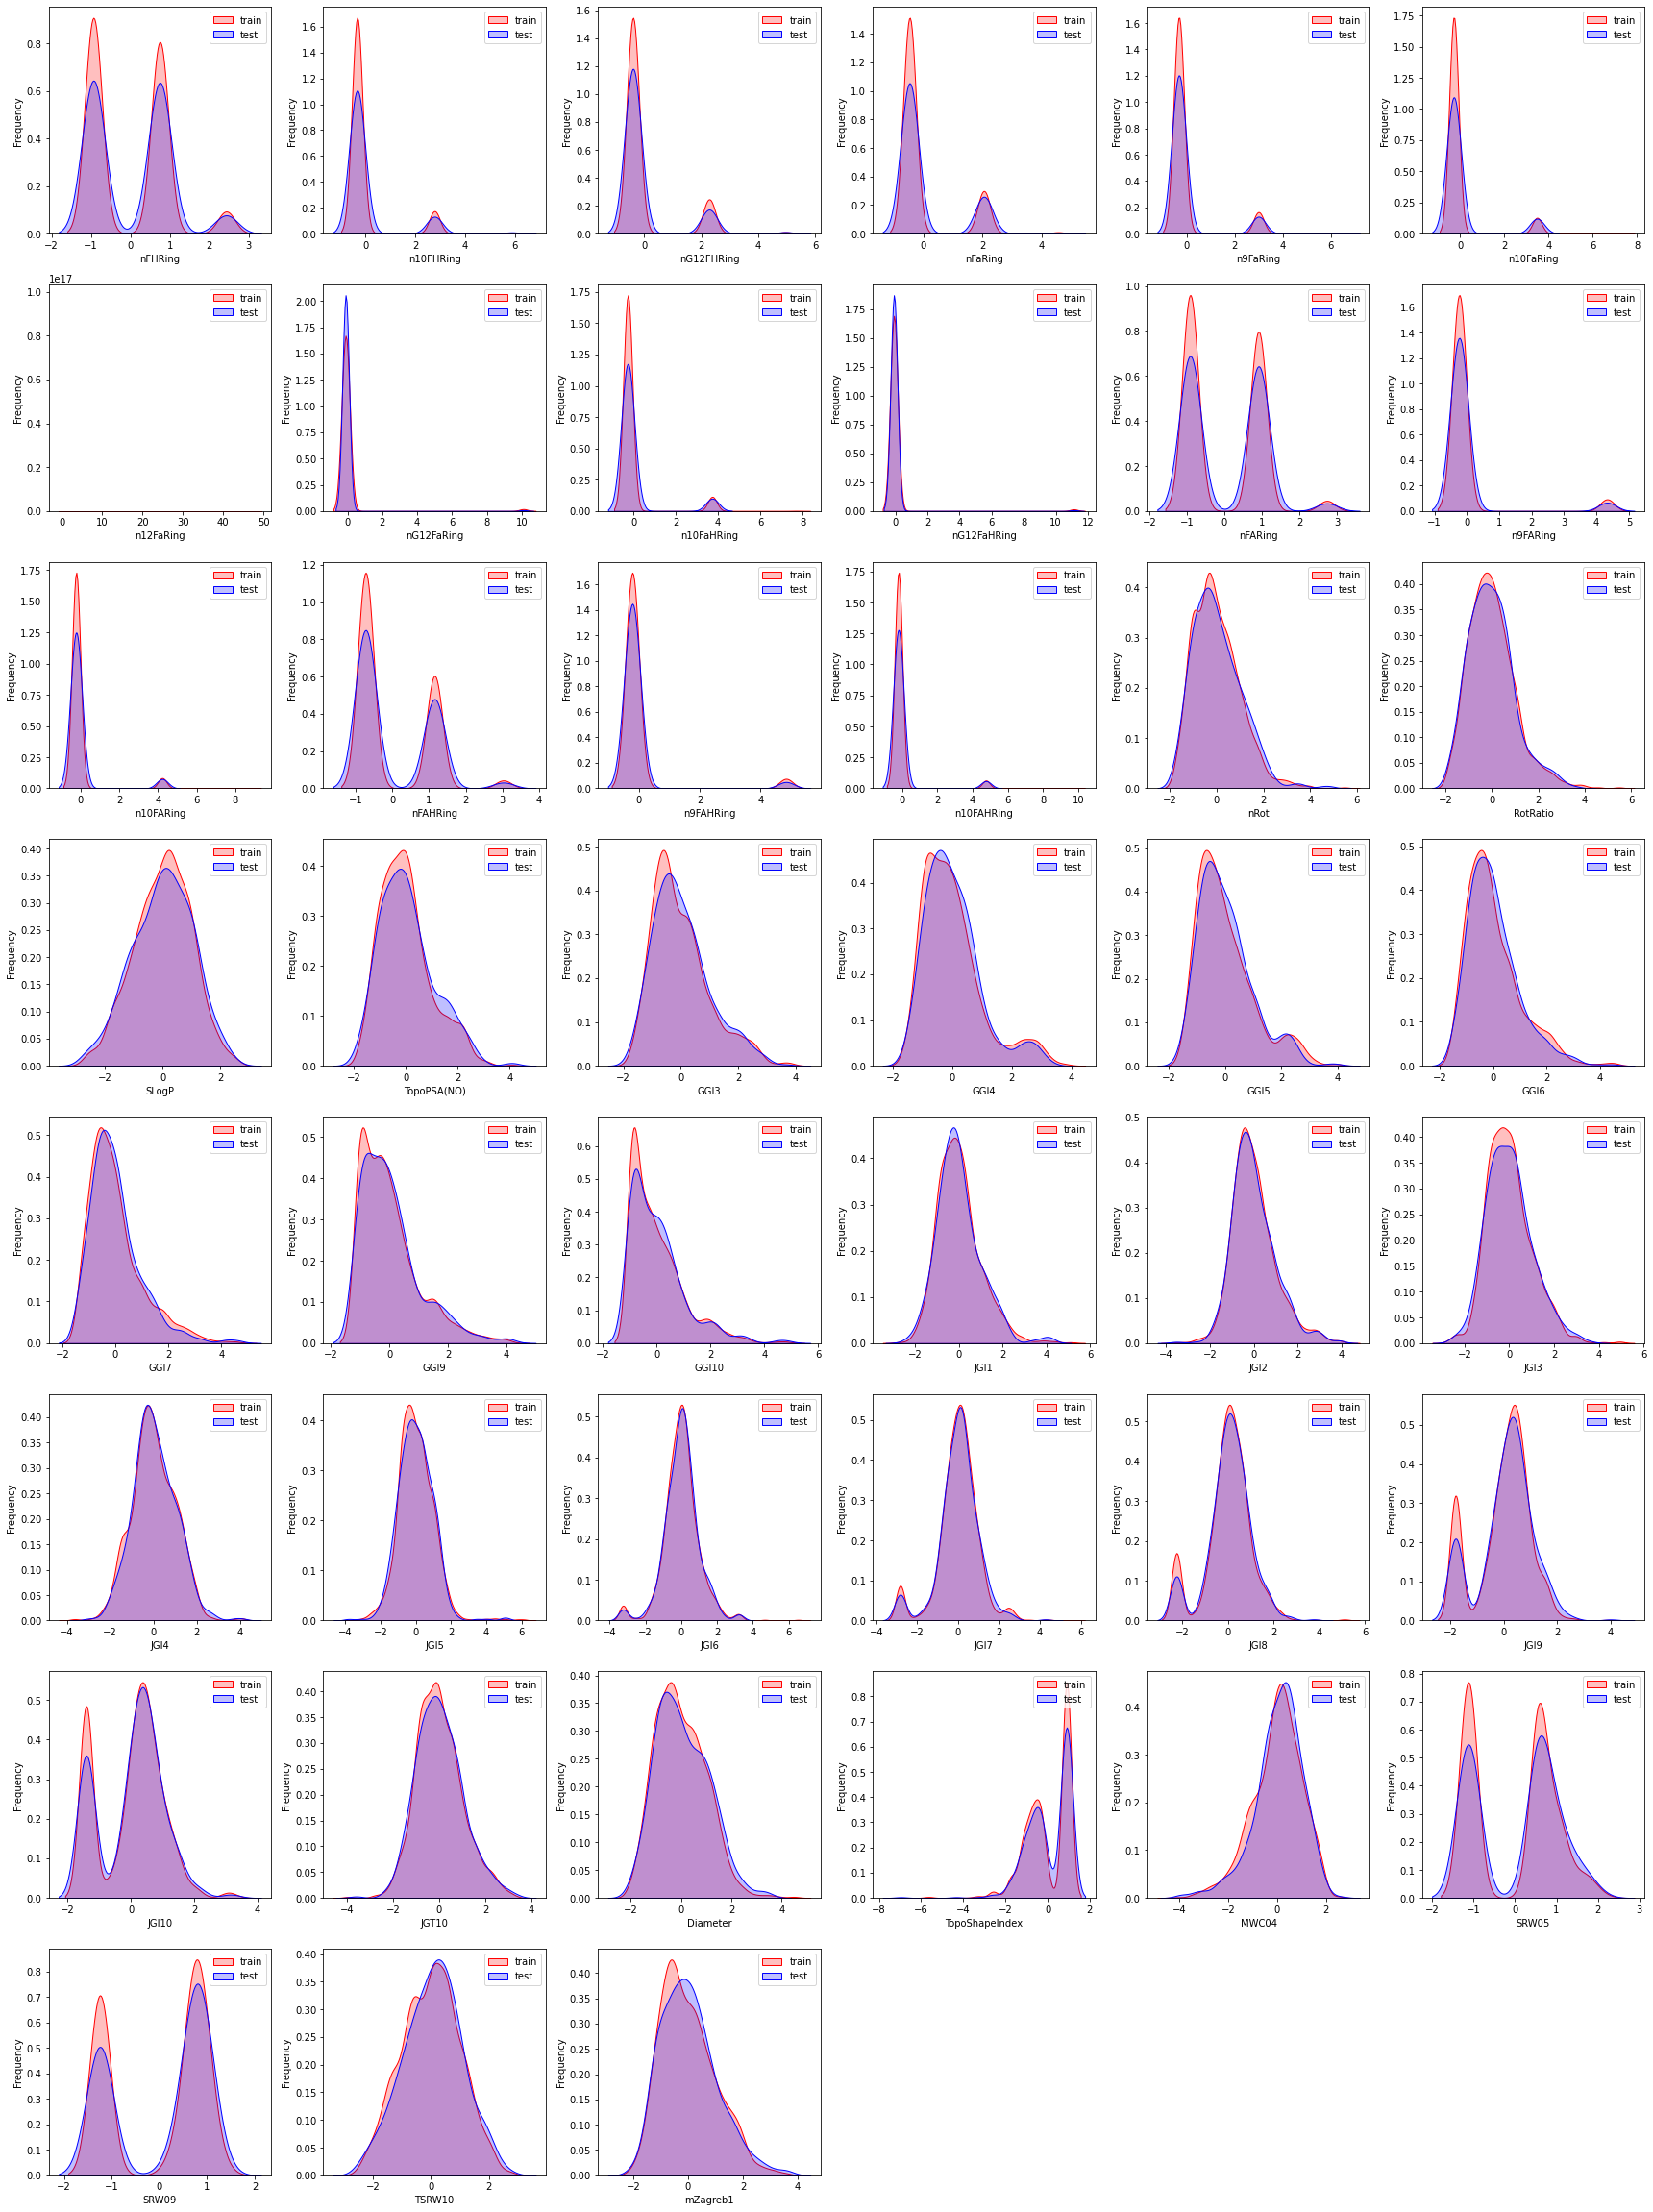

In [27]:
# draw the probability density estimates of the 651-696th features 
# in the training set and test set
train = x_train.loc[:, x_train.columns[651]:]
test = x_test.loc[:, x_test.columns[651]:]
KDE(train, test, "supplemental_fig14.png")

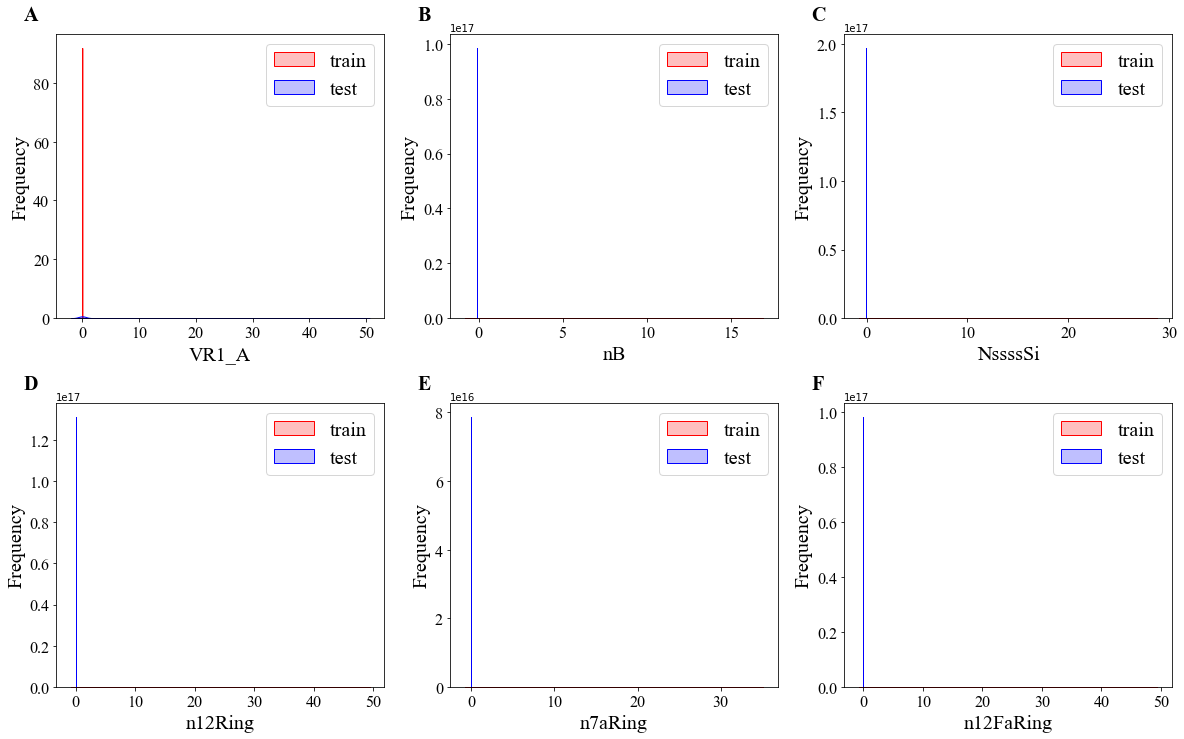

In [28]:
error_name = ['VR1_A', 'nB', 'NssssSi', 'n12Ring', 'n7aRing', 'n12FaRing']
drop_corr = drop_corr.drop(error_name, axis=1)

-0.08430448505064256 51


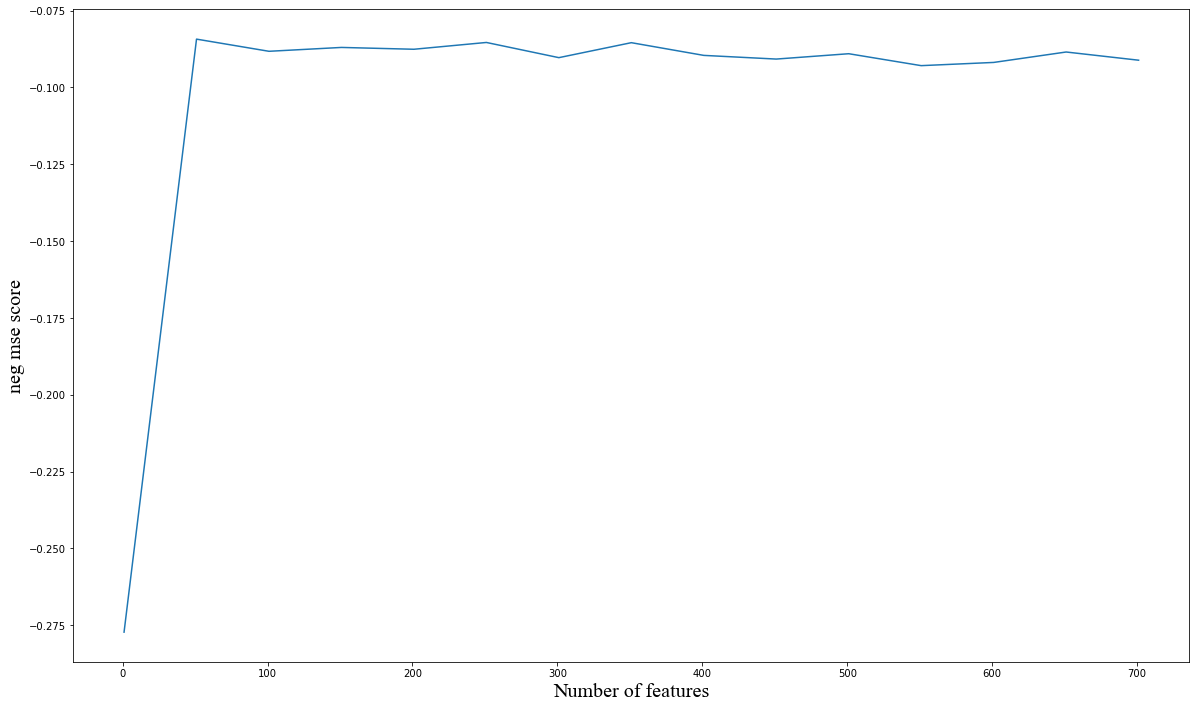

In [30]:
# build the base model XGBoost
reg = XGBR(n_estimators=100, random_state=42)
# get the maximum score within the input range and 
# the corresponding features, and draw a score chart
features_select = wrapper(1, 751, 50, drop_corr, reg)

-0.0821398995189653 141


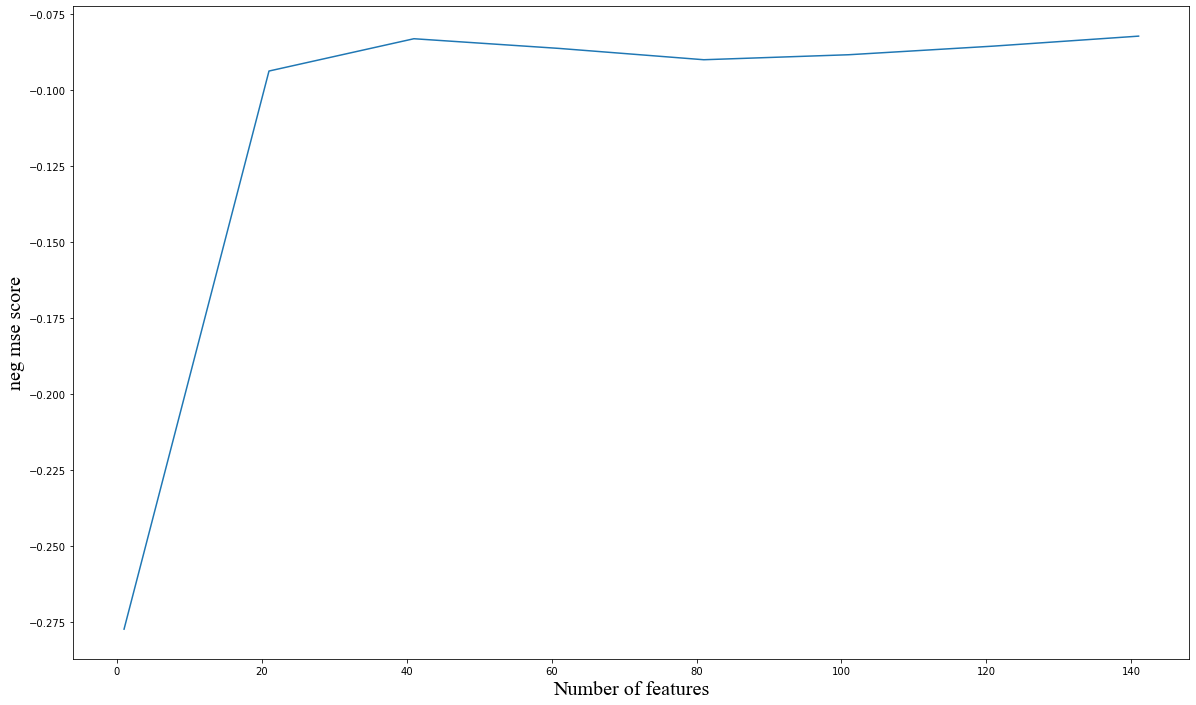

In [31]:
# Calculate the maximum score and corresponding features within the range, and draw a score trend chart
features_select = wrapper(features_select - 50, features_select + 100, 20, drop_corr, reg)

-0.0821398995189653 141


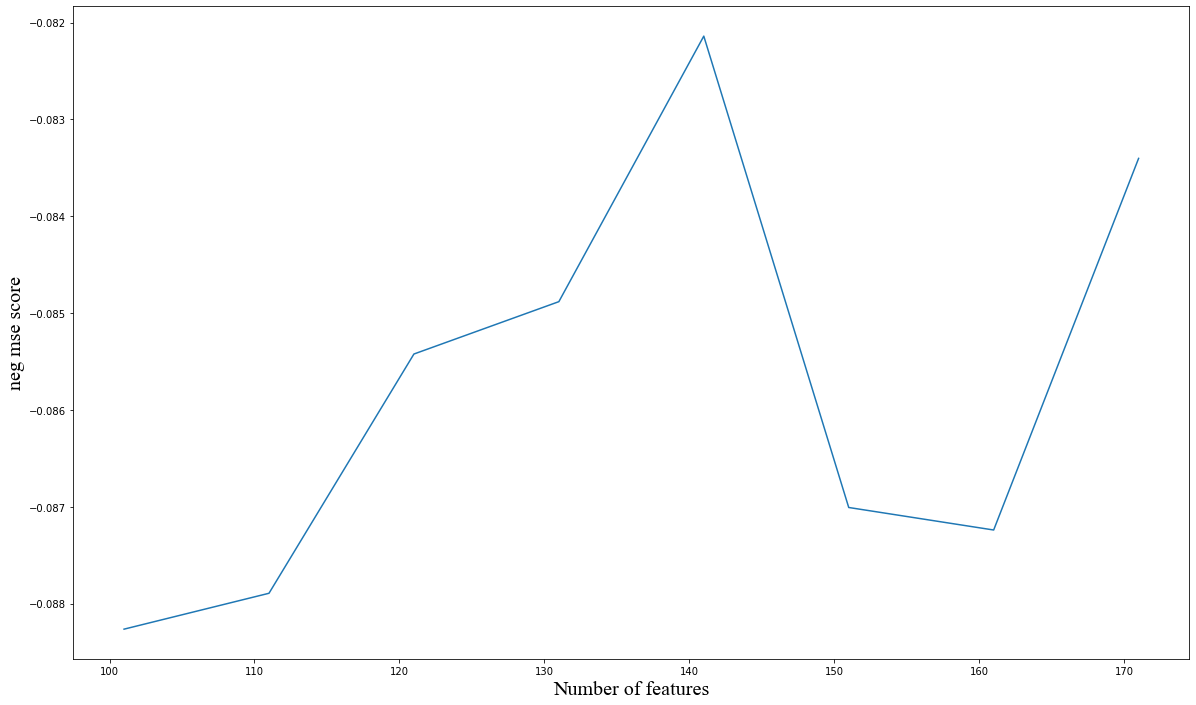

In [32]:
# refinement range
features_select = wrapper(features_select - 40, features_select + 40, 10, drop_corr, reg)

-0.0821398995189653 141


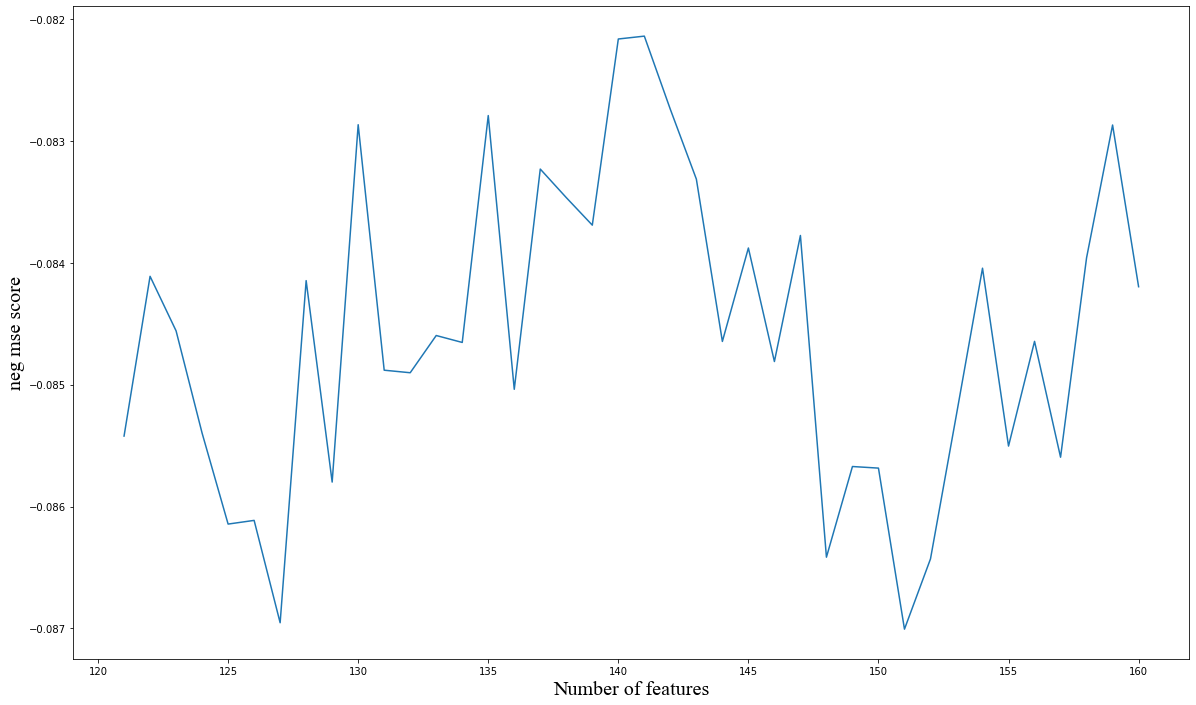

In [33]:
# refinement range
features_select = wrapper(features_select-20, features_select+20, 1, drop_corr, reg)

-0.0821398995189653 141


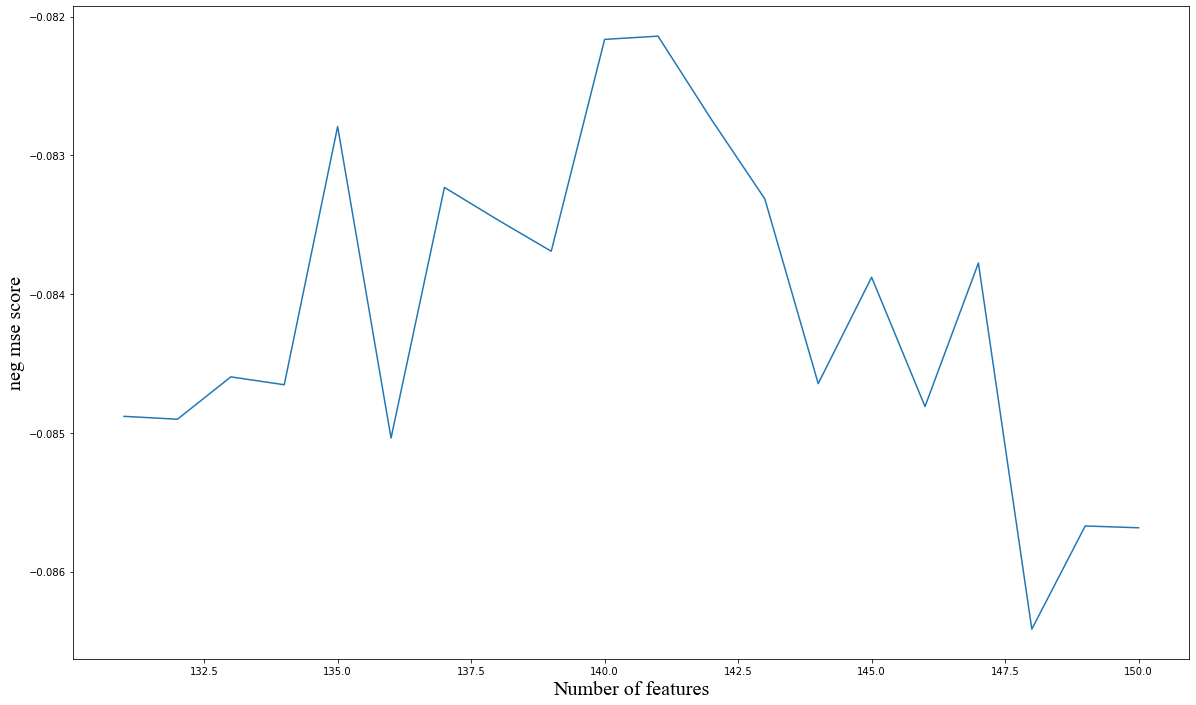

In [34]:
# refine the range to get the final number of features that need to be selected
features_select = wrapper(features_select - 10, features_select + 10, 1, drop_corr, reg)

In [35]:
# select features and calculate the score of the model XGBoost at this time
selector = RFE(reg, n_features_to_select=features_select, step=50).fit_transform(drop_corr, y)
selector = pd.DataFrame(selector)
x_train, x_test, y_train, y_test = train_test_split(selector, y, test_size=0.2, random_state=42)
XGboost_score(x_train, x_test, y_train, y_test)

XGboost score
 r2   0.8088156345054106
 MSE  0.07511599286784623
 NMSE   -0.0821398995189653
mean_r2 0.7863754914084451


In [36]:
# column names for completion features
column_name = drop_corr.columns[rfe.get_support()]
selector.columns = column_name

In [37]:
# save file
selector.to_excel("final_features.xlsx", index=False)